<a href="https://colab.research.google.com/github/Aditya3016/Aditya/blob/main/Internship_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task-1**

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

# Lists to store scraped data
Product_Name = []
Prices = []
Description = []
Reviews = []
RAM = []
ROM = []
Battery = []
Brands = []

# Known mobile brands
known_brands = [
    "Samsung", "Redmi", "Realme", "iQOO", "Vivo", "Motorola", "Infinix", "POCO",
    "Lava", "Nokia", "OnePlus", "Nothing", "Apple", "Tecno", "Micromax", "Honor"
]

# Function to extract brand from product name
def extract_brand(name):
    for brand in known_brands:
        if name.lower().startswith(brand.lower()):
            return brand
    return name.split()[0]  # fallback

headers = {"User-Agent": "Mozilla/5.0"}

# 🔄 Scrape from page 2 to 30
for i in range(2, 31):
    url = f"https://www.flipkart.com/search?q=mobiles+under+30k&page={i}"
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, "lxml")
    box = soup.find("div", class_="DOjaWF gdgoEp")

    if box is None:
        print(f"[!] Product container not found on page {i}")
        continue

    names = box.find_all("div", class_="KzDlHZ")
    prices = box.find_all("div", class_="Nx9bqj _4b5DiR")
    descriptions = box.find_all("ul", class_="G4BRas")
    reviews = box.find_all("div", class_="XQDdHH")

    min_length = min(len(names), len(prices), len(descriptions), len(reviews))

    for j in range(min_length):
        name = names[j].text.strip()
        price = prices[j].text.strip()
        desc = descriptions[j].text.strip()
        review = reviews[j].text.strip()

        # Extract RAM, ROM, Battery using regex
        ram_match = re.search(r'(\d{1,2})\s?GB\s?(RAM|Memory)', desc, re.IGNORECASE)
        rom_match = re.search(r'(\d{2,4})\s?GB\s?(ROM|Storage)', desc, re.IGNORECASE)
        battery_match = re.search(r'(\d{4,5})\s?mAh', desc, re.IGNORECASE)

        RAM.append(ram_match.group(1) + " GB" if ram_match else None)
        ROM.append(rom_match.group(1) + " GB" if rom_match else None)
        Battery.append(battery_match.group(1) + " mAh" if battery_match else None)

        # Clean description
        cleaned_desc = re.sub(r'(\d+\s?GB\s?(RAM|Memory))', '', desc, flags=re.IGNORECASE)
        cleaned_desc = re.sub(r'(\d+\s?GB\s?(ROM|Storage))', '', cleaned_desc, flags=re.IGNORECASE)
        cleaned_desc = re.sub(r'(\d{4,5}\s?mAh.*?)(Battery)?', '', cleaned_desc, flags=re.IGNORECASE)
        cleaned_desc = re.sub(r'\s{2,}', ' ', cleaned_desc).strip()

        # Append all data
        Product_Name.append(name)
        Prices.append(price)
        Description.append(cleaned_desc)
        Reviews.append(review)
        Brands.append(extract_brand(name))

# ✅ Create DataFrame
df = pd.DataFrame({
    "Brand": Brands,
    "Product Name": Product_Name,
    "Prices": Prices,
    "RAM": RAM,
    "ROM": ROM,
    "Battery": Battery,
    "Description": Description,
    "Reviews": Reviews
})

# 🚫 Remove unwanted brands
df = df[~df['Product Name'].str.contains(r'everyday|duracell', flags=re.IGNORECASE, regex=True)]

# 🔁 Remove duplicate product names
df = df.drop_duplicates(subset=['Product Name'])

# ✅ Final Check
print(f"\nTotal Products in Final Data: {len(df)}")

# 💾 Save CSV
df.to_csv(r"C:/Users/gadit/OneDrive/Desktop/FK_under_30k_final.csv", index=False)
print("[✔] Cleaned CSV with Brand column saved successfully.")


# **Loading**

**Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from scipy.sparse import csr_matrix
from wordcloud import WordCloud
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df=pd.read_csv("/content/FK_under_30k_with_brands.csv")
print(df.shape)

(635, 8)


# **EDA**

In [ ]:
#Data Cleaning
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  635 non-null    object 
 1   Prices        635 non-null    object 
 2   RAM           635 non-null    object 
 3   ROM           635 non-null    object 
 4   Battery       635 non-null    object 
 5   Description   635 non-null    object 
 6   Reviews       635 non-null    float64
 7   Brand         635 non-null    object 
dtypes: float64(1), object(7)
memory usage: 39.8+ KB
None


In [ ]:
#Check for NULL values
print(pd.isnull(df).sum())

Product Name    0
Prices          0
RAM             0
ROM             0
Battery         0
Description     0
Reviews         0
Brand           0
dtype: int64


In [ ]:
#Column Names
print(df.columns)

Index(['Product Name', 'Prices', 'RAM', 'ROM', 'Battery', 'Description',
       'Reviews', 'Brand'],
      dtype='object')


In [ ]:
#Description
print(df.describe())

          Reviews
count  635.000000
mean     4.300945
std      0.191538
min      3.200000
25%      4.200000
50%      4.300000
75%      4.400000
max      4.800000


*Rating Distribution*

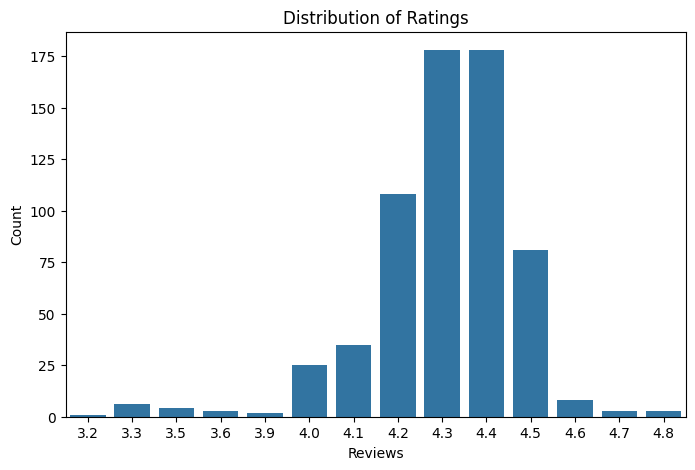

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='Reviews', data=df)
plt.title("Distribution of Ratings")
plt.xlabel("Reviews")
plt.ylabel("Count")
plt.show()

*Price Distribution Plot*

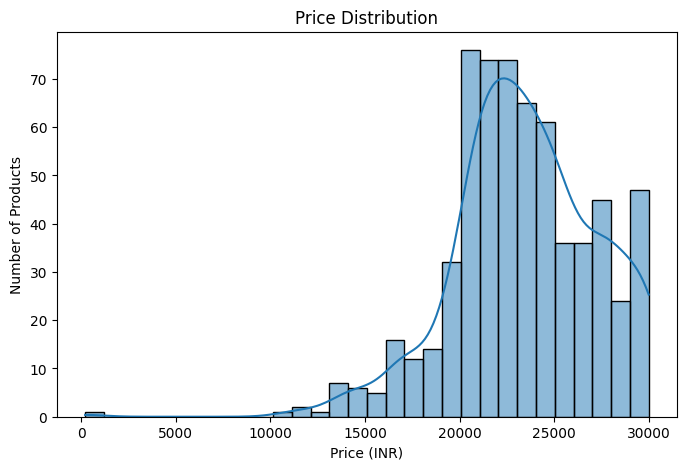

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

  df['Prices'] = df['Prices'].str.replace('₹','').str.replace(',','').astype(float)

  plt.figure(figsize=(8, 5))
  sns.histplot(df['Prices'], bins=30, kde=True)
  plt.title("Price Distribution")
  plt.xlabel("Price (INR)")
  plt.ylabel("Number of Products")
  plt.show()

*Top Brands by Frequency*

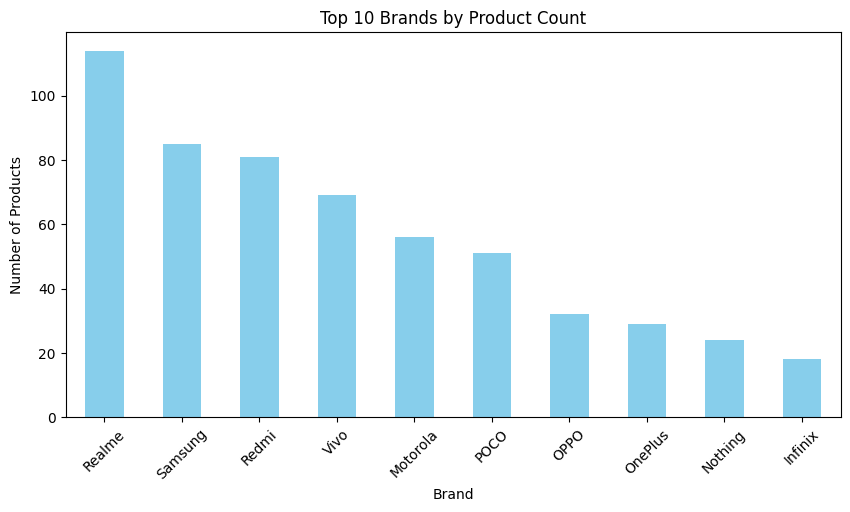

In [ ]:
plt.figure(figsize=(10, 5))
df['Brand'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Brands by Product Count")
plt.xlabel("Brand")
plt.ylabel("Number of Products")
plt.xticks(rotation=45)
plt.show()

*RAM Distribution*

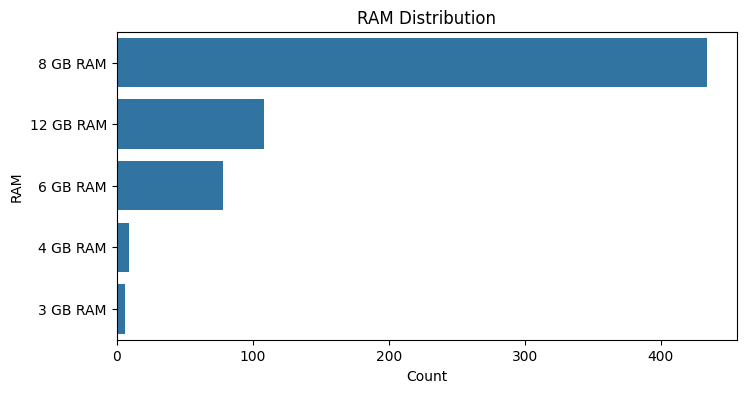

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(y=df['RAM'].dropna(), order=df['RAM'].value_counts().index)
plt.title("RAM Distribution")
plt.xlabel("Count")
plt.ylabel("RAM")
plt.show()

*Missing Value Heatmap*

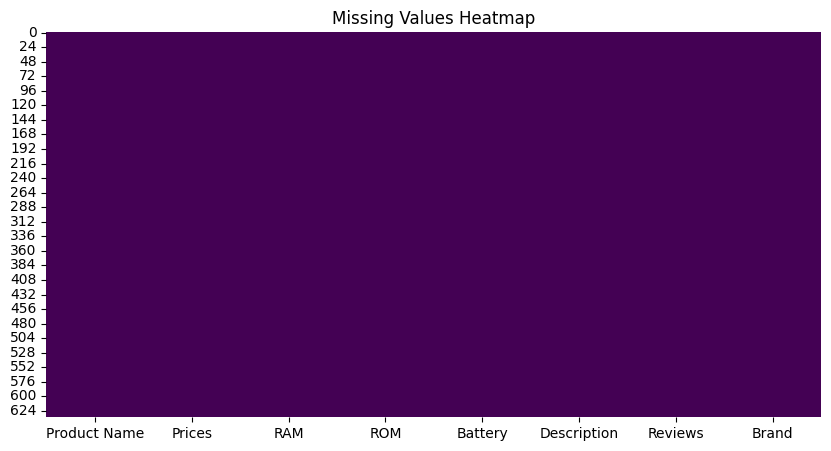

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

*TF-IDF Vectorization on Description*

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Description'].fillna(''))

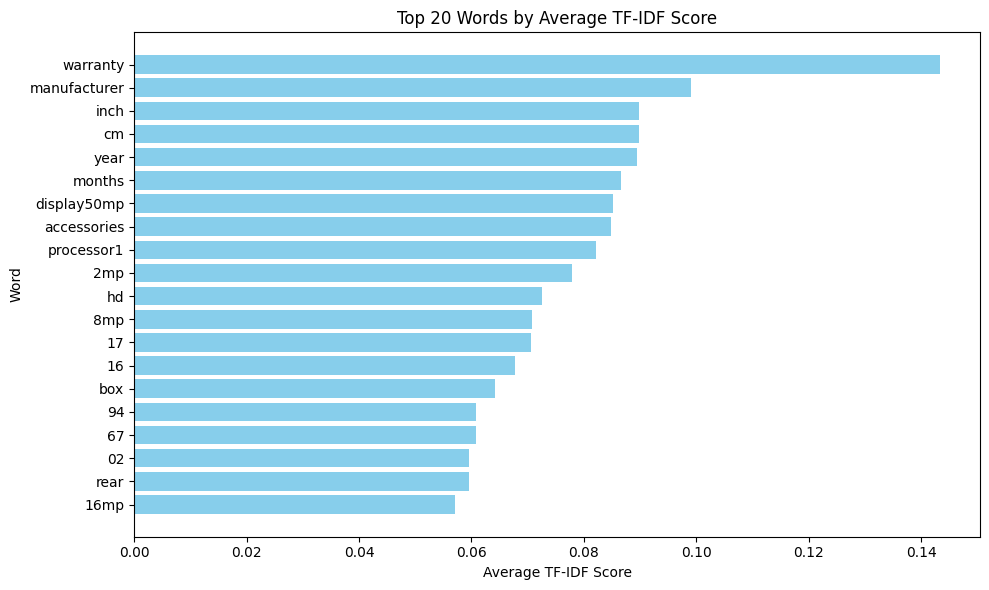

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names and average TF-IDF scores
feature_names = tfidf.get_feature_names_out()
avg_tfidf_scores = tfidf_matrix.mean(axis=0).A1  # Convert sparse matrix to flat array

# Create DataFrame of words and scores
tfidf_df = pd.DataFrame({
    'word': feature_names,
    'avg_score': avg_tfidf_scores
})

# Sort and plot top 20
top_words = tfidf_df.sort_values(by='avg_score', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_words['word'][::-1], top_words['avg_score'][::-1], color='skyblue')
plt.title("Top 20 Words by Average TF-IDF Score")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

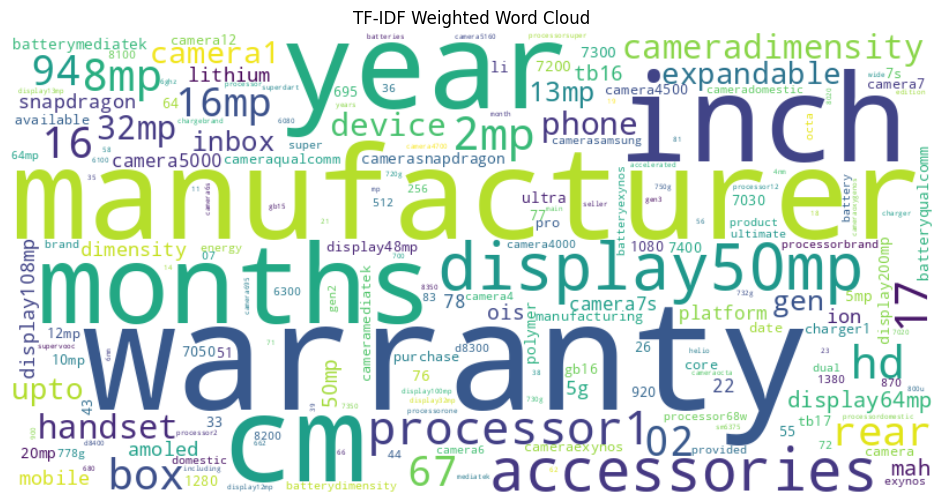

In [ ]:
from wordcloud import WordCloud

# Create dictionary of word: avg_score
word_scores = dict(zip(tfidf_df['word'], tfidf_df['avg_score']))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("TF-IDF Weighted Word Cloud")
plt.show()

*Cosine Similarity Matrix*

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

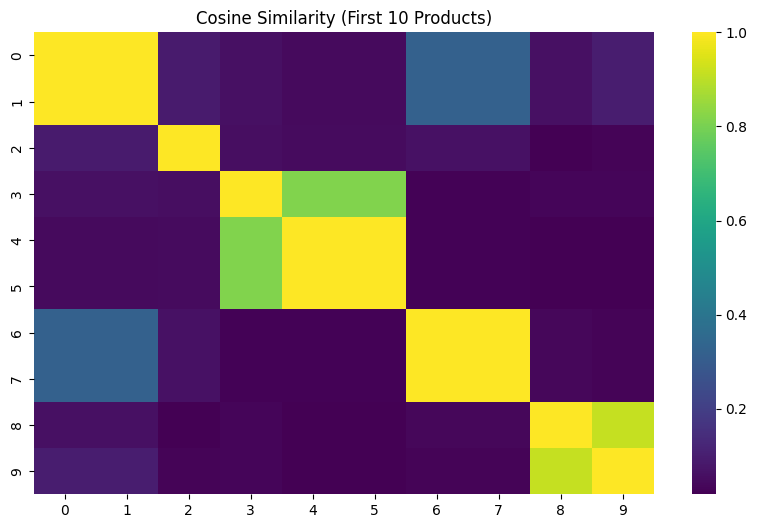

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(cosine_sim[:10, :10], cmap='viridis')
plt.title("Cosine Similarity (First 10 Products)")
plt.show()

# **Recommendation Function**

In [ ]:
indices = pd.Series(df.index, index=df['Product Name']).drop_duplicates()


from difflib import get_close_matches
def get_recommendations(product_name, cosine_sim=cosine_sim):
    matches = get_close_matches(product_name, df['Product Name'], n=1, cutoff=0.5)
    if not matches:
        print(f"[!] No close match found for '{product_name}'")
        return []
    matched_name = matches[0]
    idx = df[df['Product Name'] == matched_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    product_indices = [i[0] for i in sim_scores]


    print(f"Showing recommendations for: {matched_name}")
    return df['Product Name'].iloc[product_indices]

*Test the Recommender*

In [ ]:
df['Product Name'].head(10).tolist()

['Alcatel V3 Ultra 5G (Hyper Blue, 128 GB)',
 'Alcatel V3 Ultra 5G (Ocean Grey, 128 GB)',
 'ASUS Zenfone 4 Selfie Pro (Red, 64 GB)',
 'BlackBerry Keyone (Silver, 32 GB)',
 'BlackBerry passport (Black, 32 GB)',
 'BlackBerry Passport (Black, 32 GB)',
 'CMF by Nothing Phone 2 Pro (Light Green, 256 GB)',
 'CMF by Nothing Phone 2 Pro (Orange, 256 GB)',
 'Google Pixel 7a (Charcoal, 128 GB)',
 'Google Pixel 7a (Sea, 128 GB)']

In [ ]:
get_recommendations("Redmi Note 12")

[!] No close match found for 'Redmi Note 12'


[]

In [ ]:
get_recommendations("Samsung Galaxy M14 5G (Smoky Teal, 128 GB)")

Showing recommendations for: Samsung Galaxy A16 5G (Gold, 128 GB)


,Product Name
469,"Samsung Galaxy A16 5G (Light Green, 256 GB)"
188,"OPPO A5 Pro 5G (Feather Blue, 256 GB)"
189,"OPPO A5 Pro 5G (Mocha Brown, 256 GB)"
194,"OPPO F27 5G (Aber Orange, 128 GB)"
203,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...


# **Plots**

*Reviews Distribution Plot*

<Axes: xlabel='Reviews', ylabel='Count'>

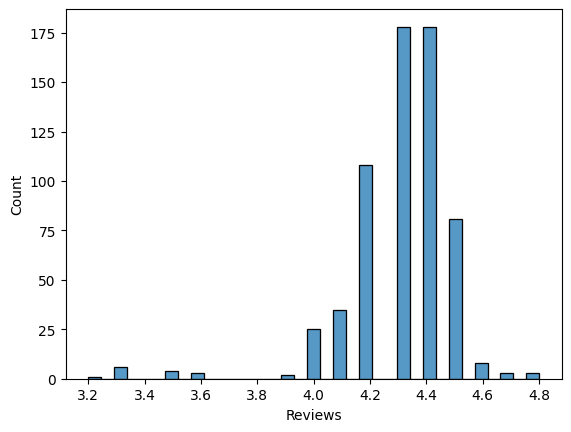

In [ ]:
sns.histplot(df['Reviews'])

*Top Brands by Count*

<Axes: xlabel='Brand'>

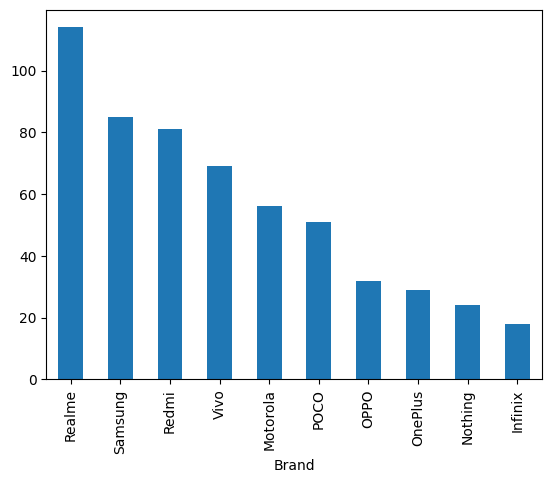

In [ ]:
df['Brand'].value_counts().head(10).plot(kind='bar')

*Missing Value Heatmap*

<Axes: >

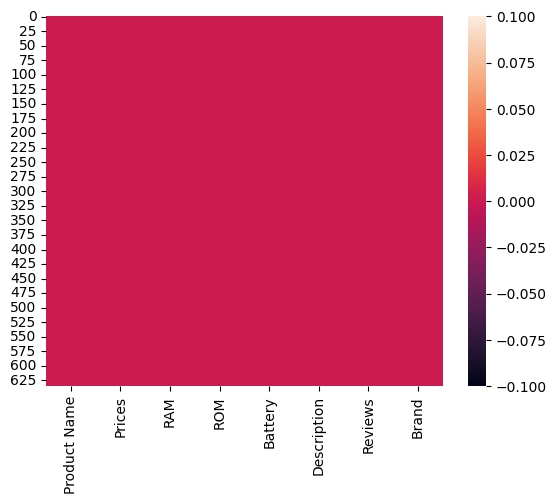

In [ ]:
sns.heatmap(df.isnull())

*RAM Distribution*

<Axes: xlabel='count', ylabel='RAM'>

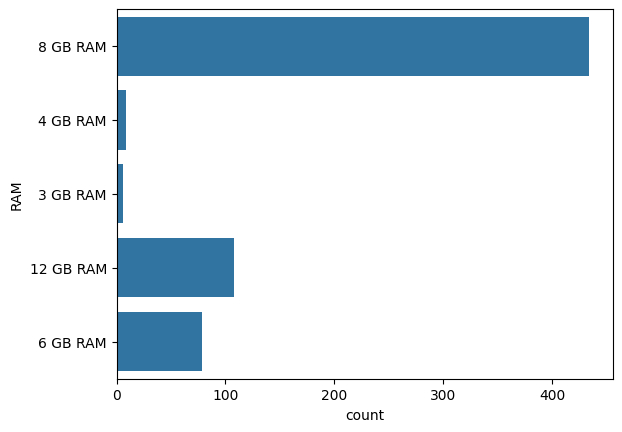

In [ ]:
sns.countplot(df['RAM'])

*ROM Distribution*

<Axes: xlabel='count', ylabel='ROM'>

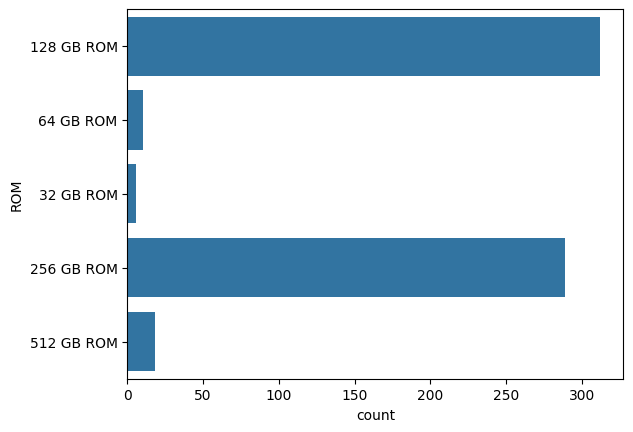

In [ ]:
sns.countplot(df['ROM'])

# **Extra-2**

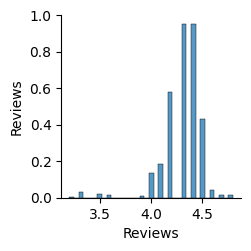

In [ ]:
#EDA
#Plot graph
sns.pairplot(df)

In [ ]:
df_sorted = (
    df.groupby('RAM', as_index=False)
      .size()
      .rename(columns={'size': 'Count'})
)

# Step 2: Extract numeric RAM size for sorting
df_sorted['RAM_Size'] = df_sorted['RAM'].str.extract(r'(\d+)').astype(float)

# Step 3: Sort by that extracted numeric value
df_sorted = df_sorted.sort_values(by='RAM_Size', ascending=True)

# Step 4: Clean RAM column — remove "RAM" word but keep units (e.g., "4 GB")
df_sorted['RAM'] = df_sorted['RAM'].str.replace(r'\s*RAM', '', regex=True).str.strip()

# Step 5: Drop helper column
df_sorted = df_sorted.drop(columns='RAM_Size')

# Step 6: Print final result
print(df_sorted)

     RAM  Count
1   3 GB      6
2   4 GB      9
3   6 GB     78
4   8 GB    434
0  12 GB    108


In [ ]:
# Step 1: Group by ROM and count
df_sort= (
    df.groupby('ROM', as_index=False)
      .size()
      .rename(columns={'size': 'Count'})
)

# Step 2: Extract numeric RAM size for sorting
df_sort['ROM_size'] = df_sort['ROM'].str.extract(r'(\d+)').astype(float)

# Step 3: Sort by that extracted numeric value
df_sort = df_sort.sort_values(by='ROM_size', ascending=True)

# Step 4: Clean RAM column — remove "RAM" word but keep units (e.g., "4 GB")
df_sort['ROM'] = df_sort['ROM'].str.replace(r'\s*ROM', '', regex=True).str.strip()

# Step 5: Drop helper column
df_sort = df_sort.drop(columns='ROM_size')

# Step 6: Print final result
print(df_sort)

      ROM  Count
2   32 GB      6
4   64 GB     10
0  128 GB    312
1  256 GB    289
3  512 GB     18


<Axes: xlabel='RAM', ylabel='Count'>

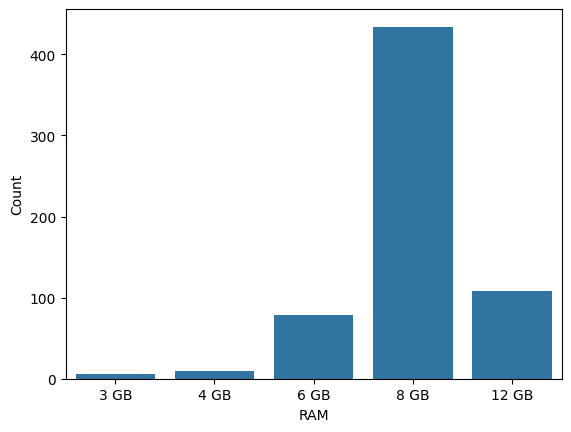

In [ ]:
sns.barplot(x='RAM',y='Count',data=df_sorted)

In [ ]:
# 🧠 RAM: Group, Count, Sort, Clean
df_ram = (
    df.groupby('RAM', as_index=False)
      .size()
      .rename(columns={'size': 'Count'})
)

# Extract numeric part for sorting
df_ram['RAM_Size'] = df_ram['RAM'].str.extract(r'(\d+)').astype(float)

# Sort and clean
df_ram = df_ram.sort_values(by='RAM_Size', ascending=True)
df_ram['RAM'] = df_ram['RAM'].str.replace(r'\s*RAM', '', regex=True).str.strip()
df_ram = df_ram.drop(columns='RAM_Size')

# 🧠 ROM: Group, Count, Sort, Clean
df_rom = (
    df.groupby('ROM', as_index=False)
      .size()
      .rename(columns={'size': 'Count'})
)

# Extract numeric part for sorting
df_rom['ROM_Size'] = df_rom['ROM'].str.extract(r'(\d+)').astype(float)

# Sort and clean
df_rom = df_rom.sort_values(by='ROM_Size', ascending=True)
df_rom['ROM'] = df_rom['ROM'].str.replace(r'\s*ROM', '', regex=True).str.strip()
df_rom = df_rom.drop(columns='ROM_Size')

# 🖨️ Output
print("📌 Sorted RAM Count Table:\n", df_ram, "\n")
print("📌 Sorted ROM Count Table:\n", df_rom)

📌 Sorted RAM Count Table:
      RAM  Count
1   3 GB      6
2   4 GB      9
3   6 GB     78
4   8 GB    434
0  12 GB    108 

📌 Sorted ROM Count Table:
       ROM  Count
2   32 GB      6
4   64 GB     10
0  128 GB    312
1  256 GB    289
3  512 GB     18


In [ ]:
# Step 0: Remove rows where RAM or ROM is missing
df_filtered = df.dropna(subset=['RAM', 'ROM'])

# Step 1: Extract and clean numeric values
df_filtered['Clean_RAM'] = df_filtered['RAM'].str.extract(r'(\d+)').astype(float).astype('Int64').astype(str) + 'GB'
df_filtered['Clean_ROM'] = df_filtered['ROM'].str.extract(r'(\d+)').astype(float).astype('Int64').astype(str) + 'GB'

# Step 2: Build the combo
df_filtered['RAM_ROM'] = df_filtered['Clean_RAM'] + '–' + df_filtered['Clean_ROM']

/tmp/ipython-input-11-783028378.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=combo_counts, x='RAM_ROM', y='Phone Count', palette='viridis')


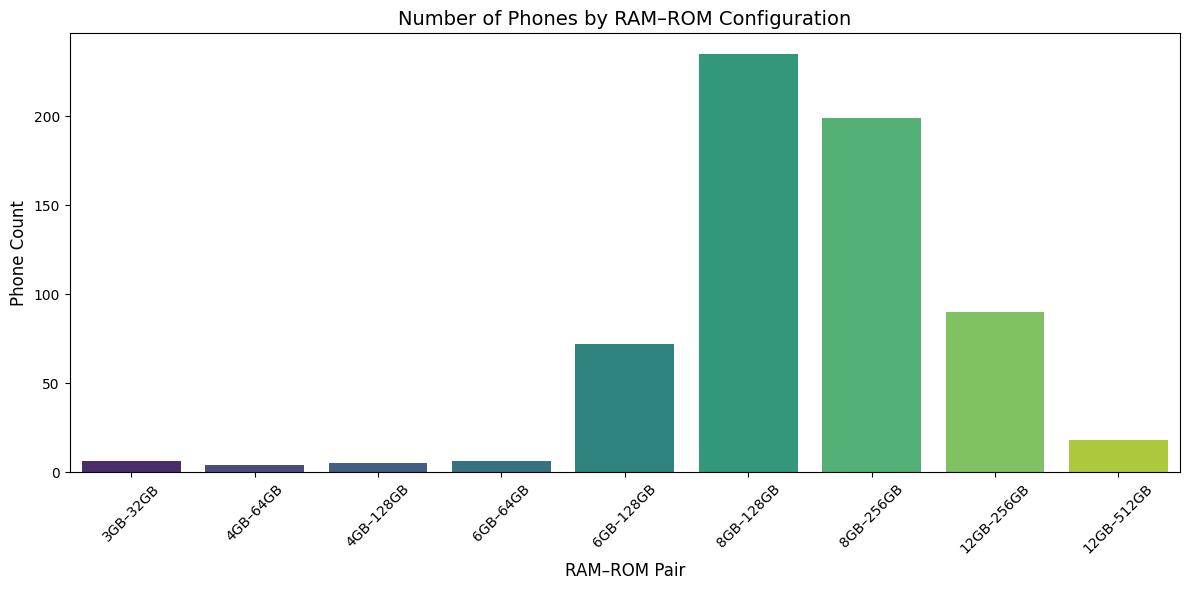

In [ ]:
# 🧹 Step 1: Clean RAM and ROM columns
df['Clean_RAM'] = df['RAM'].str.extract(r'(\d+)').astype(str) + 'GB'
df['Clean_ROM'] = df['ROM'].str.extract(r'(\d+)').astype(str) + 'GB'

# 🧱 Step 2: Create combined RAM–ROM pair label
df['RAM_ROM'] = df['Clean_RAM'] + '–' + df['Clean_ROM']

# 🧮 Step 3: Count number of phones per unique RAM–ROM combo
combo_counts = df['RAM_ROM'].value_counts().reset_index()
combo_counts.columns = ['RAM_ROM', 'Phone Count']

# 🧠 Step 4: Extract RAM and ROM sizes for numeric sorting (handle NaNs safely)
combo_counts['RAM_Size'] = combo_counts['RAM_ROM'].str.extract(r'(\d+)').astype(float)
combo_counts['ROM_Size'] = combo_counts['RAM_ROM'].str.extract(r'\D+–(\d+)').astype(float)

# 🚫 Drop any rows where either size couldn't be extracted
combo_counts = combo_counts.dropna(subset=['RAM_Size', 'ROM_Size'])

# 📊 Step 5: Sort by RAM then ROM
combo_counts = combo_counts.sort_values(by=['RAM_Size', 'ROM_Size']).drop(columns=['RAM_Size', 'ROM_Size'])

# 🎨 Step 6: Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=combo_counts, x='RAM_ROM', y='Phone Count', palette='viridis')
plt.title("Number of Phones by RAM–ROM Configuration", fontsize=14)
plt.xlabel("RAM–ROM Pair", fontsize=12)
plt.ylabel("Phone Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

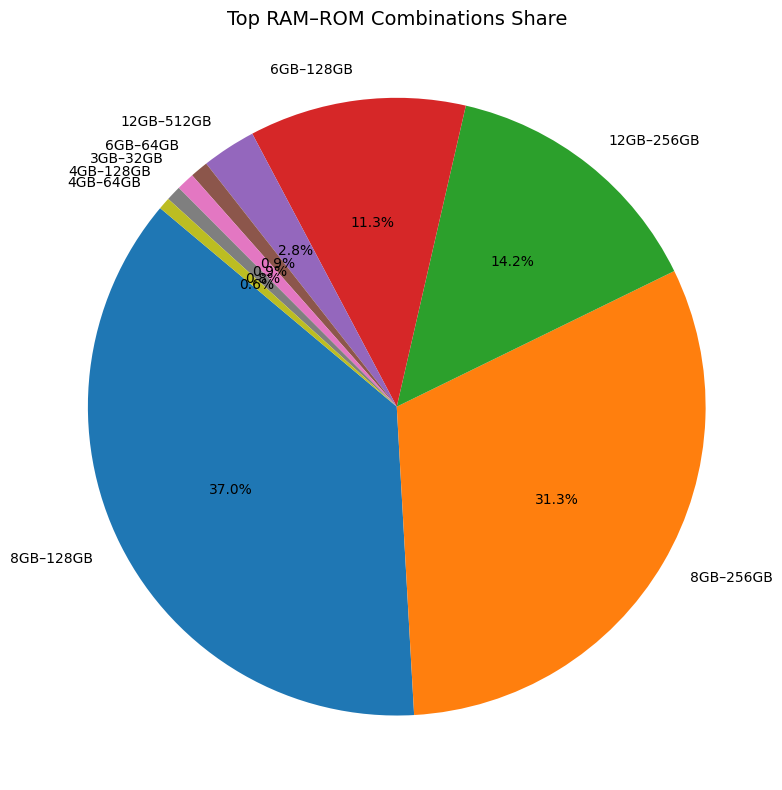

In [ ]:
# Step 1: Prepare the Data
combo_counts = df_filtered['RAM_ROM'].value_counts().reset_index()
combo_counts.columns = ['RAM_ROM', 'Count']

# Step 2: Plot the Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(combo_counts['Count'], labels=combo_counts['RAM_ROM'], autopct='%1.1f%%', startangle=140)
plt.title('Top RAM–ROM Combinations Share', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures circular pie
plt.tight_layout()
plt.show()

# **Content-Based Recommendation**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack

# Step 1: Load dataset
df = pd.read_csv("/content/your_file_cleaned.csv")

# Step 2: Clean numerical columns

# Clean Price
df['Prices'] = df['Prices'].astype(str).str.replace('₹', '', regex=False).str.replace(',', '', regex=False)
df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')

# Clean Battery
df['Battery'] = df['Battery'].astype(str).str.replace('mAh', '', regex=False).str.replace(',', '', regex=False).str.strip()
df['Battery'] = pd.to_numeric(df['Battery'], errors='coerce')

# Clean Review Score from Reviews
df['Reviews'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Drop rows with missing essentials
df = df.dropna(subset=['Product Name', 'Description', 'Prices', 'RAM', 'ROM', 'Battery', 'Reviews'])

# Step 3: TF-IDF Vectorization on Description
tfidf = TfidfVectorizer(stop_words='english', max_features=300)
tfidf_matrix = tfidf.fit_transform(df['Description'].astype(str))

# Step 4: One-Hot Encode RAM & ROM
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ram_rom_encoded = encoder.fit_transform(df[['RAM', 'ROM']].astype(str))

# Step 5: Scale Price, Battery, Review_Score
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(df[['Prices', 'Reviews', 'Battery']])

# Step 6: Combine All Features
combined_features = hstack([tfidf_matrix, ram_rom_encoded, numeric_features])

# Step 7: Compute Cosine Similarity
cosine_sim = cosine_similarity(combined_features, combined_features)

# ✅ Check alignment
print("Cosine similarity shape:", cosine_sim.shape)
print("DataFrame length:", len(df))

# Step 8: Map product names to indices
product_indices = pd.Series(df.index, index=df['Product Name']).drop_duplicates()

# Step 9: Recommender Function with Category Breakdown
def recommend(product_name, num_recommendations=5):
    if product_name not in product_indices:
        print(f"[!] Product '{product_name}' not found.")
        return []

    idx = product_indices[product_name]
    sim_scores = list(enumerate(cosine_sim[idx].flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    indices = [i[0] for i in sim_scores]

    # ✅ Filter out any invalid indices
    valid_indices = [i for i in indices if i < len(df)]

    results = df.iloc[valid_indices].copy()


    # Categorization
    results['Price Category'] = pd.cut(results['Prices'], bins=[0, 12000, 18000, 25000, 35000],
                                       labels=['Budget', 'Mid-Range', 'Upper Mid', 'Premium'])
    results['Battery Level'] = pd.cut(results['Battery'], bins=[0, 4000, 5000, 6000, 7000],
                                      labels=['Low', 'Avg', 'Good', 'Monster'])
    results['RAM Info'] = results['RAM'].astype(str) + " RAM"
    results['ROM Info'] = results['ROM'].astype(str) + " Storage"

    return results[['Product Name', 'Prices', 'Price Category', 'Battery', 'Battery Level',
                    'RAM Info', 'ROM Info', 'Reviews']]

# 🔍 Example Usage
query = "Honor 90 5G (Midnight Black, 512 GB)"
print(f"📱 Recommended for: {query}")
print(recommend(query))

Cosine similarity shape: (563, 563)
DataFrame length: 563
📱 Recommended for: Honor 90 5G (Midnight Black, 512 GB)
                            Product Name  Prices Price Category  Battery  \
17  Honor 90 5G (Midnight Black, 512 GB)   21695      Upper Mid     5000   
18  Honor 90 5G (Midnight Black, 512 GB)   28999        Premium     5000   

   Battery Level       RAM Info            ROM Info  Reviews  
17           Avg  12 GB RAM RAM  512 GB ROM Storage      4.2  
18           Avg  12 GB RAM RAM  512 GB ROM Storage      4.2  


In [ ]:
from difflib import get_close_matches

def recommend(product_name, num_recommendations=5):
    # Rebuild index mapping to ensure it's in sync with df
    product_indices = pd.Series(df.index, index=df['Product Name']).drop_duplicates()

    # Fuzzy match the input name to the closest product name
    matches = get_close_matches(product_name, df['Product Name'], n=1, cutoff=0.5)

    if not matches:
        print(f"[!] No close match found for '{product_name}'")
        return []

    matched_name = matches[0]
    idx = df[df['Product Name'] == matched_name].index[0]

    # Compute similarity scores
    sim_scores = list(enumerate(cosine_sim[idx].flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    indices = [i[0] for i in sim_scores]
    results = df.iloc[indices].copy()

    # Categorization
    results['Price Category'] = pd.cut(results['Prices'], bins=[0, 12000, 18000, 25000, 35000],
                                       labels=[' Budget', ' Mid-Range', ' Upper Mid', ' Premium'])
    results['Battery Level'] = pd.cut(results['Battery'], bins=[0, 4000, 5000, 6000, 7000],
                                      labels=[' Low', ' Avg', ' Good', ' Monster'])
    results['RAM Info'] = results['RAM'].astype(str) + " RAM"
    results['ROM Info'] = results['ROM'].astype(str) + " Storage"

    # Display results
    print(f"\n Recommendations for: {matched_name}\n")
    return results[['Product Name', 'Prices', 'Price Category', 'Battery', 'Battery Level',
                    'RAM Info', 'ROM Info', 'Reviews']]

recommend("Nothing Phone (3a) Pro")


 Recommendations for: Nothing Phone (3a) Pro (Black, 128 GB)



,Product Name,Prices,Price Category,Battery,Battery Level,RAM Info,ROM Info,Reviews
134,"Nothing Phone (3a) (Black, 128 GB)",24999,Upper Mid,5000,Avg,8 GB RAM RAM,128 GB ROM Storage,4.5
135,"Nothing Phone (3a) (Blue, 128 GB)",24999,Upper Mid,5000,Avg,8 GB RAM RAM,128 GB ROM Storage,4.5
137,"Nothing Phone (3a) (White, 128 GB)",24999,Upper Mid,5000,Avg,8 GB RAM RAM,128 GB ROM Storage,4.5
124,"Nothing Phone (2a) 5G (Blue, 128 GB)",27990,Premium,5000,Avg,8 GB RAM RAM,128 GB ROM Storage,4.4
521,"vivo V30 5G (Classic Black, 128 GB)",27508,Premium,5000,Avg,8 GB RAM RAM,128 GB ROM Storage,4.5


# **Item-Item Collaborative Filtering**

In [ ]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("/content/FK_cleaned.csv")

# Extract Review_Score from Reviews
df['Review_Score'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
df['Review_Score'] = pd.to_numeric(df['Review_Score'], errors='coerce')

# Drop missing scores/products
df = df.dropna(subset=['Product Name', 'Review_Score'])

# Simulate user_id if not present
if 'user_id' not in df.columns:
    np.random.seed(42)
    df['user_id'] = np.random.randint(1, 101, size=len(df))  # 100 synthetic users

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Create item–user matrix
item_user_matrix = df.pivot_table(index='Product Name', columns='user_id', values='Review_Score').fillna(0)

# Compute item–item similarity matrix
item_sim_matrix = cosine_similarity(item_user_matrix)
item_sim_df = pd.DataFrame(item_sim_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)

In [ ]:
def item_collab_recommend(product_name, sim_df=item_sim_df, top_n=5):
    product_name = product_name.strip()
    if product_name not in sim_df.index:
        return f"Product '{product_name}' not found."

    similar_items = sim_df[product_name].sort_values(ascending=False)[1:top_n+1]
    return pd.DataFrame({
        'Recommended Product': similar_items.index,
        'Similarity Score': similar_items.values
    })

#Example usage
query = "realme Narzo 60x 5G (Stellar Green, 128 GB)"
print(f"Recommendations for: {query}")
print(item_collab_recommend(query))

Recommendations for: realme Narzo 60x 5G (Stellar Green, 128 GB)
Product 'realme Narzo 60x 5G (Stellar Green, 128 GB)' not found.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display  # 👈 For clean table output in notebooks

# STEP 1: Load and Clean Ratings
df = pd.read_csv("/content/FK_cleaned.csv")

# Extract ratings from Reviews column
df['Review_Score'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
df['Review_Score'] = pd.to_numeric(df['Review_Score'], errors='coerce')
df = df.dropna(subset=['Product Name', 'Review_Score'])

# Simulate user_id if not present
if 'user_id' not in df.columns:
    np.random.seed(42)
    df['user_id'] = np.random.randint(1, 101, size=len(df))  # 100 synthetic users

# STEP 2: Create Item-User Matrix + Cosine Similarity
item_user_matrix = df.pivot_table(index='Product Name', columns='user_id', values='Review_Score').fillna(0)
item_sim_matrix = cosine_similarity(item_user_matrix)
item_sim_df = pd.DataFrame(item_sim_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)

# STEP 3: Collaborative Recommender with Fallback
def item_collab_recommend(product_name, top_n=5):
    product_name = product_name.strip()

    if product_name not in item_sim_df.index:
        print(f"Product '{product_name}' not found in similarity matrix.")
        print("Showing most highly rated products instead:\n")

        top_rated = (
            df.groupby('Product Name')['Review_Score']
            .mean()
            .sort_values(ascending=False)
            .head(top_n)
            .reset_index()
        )
        return top_rated.rename(columns={'Review_Score': 'Avg Rating'})

    similar_items = item_sim_df[product_name].sort_values(ascending=False)[1:top_n+1]
    results = df[df['Product Name'].isin(similar_items.index)].copy()

    return results[[
        'Product Name', 'Prices', 'Battery', 'RAM', 'ROM', 'Review_Score'
    ]].drop_duplicates().sort_values(by='Review_Score', ascending=False).reset_index(drop=True)

# STEP 4: Try with an Invalid Product Name
invalid_query = "Samsung Galaxy Z99 Ultra"
print(f"\n Trying with product: '{invalid_query}'")
display(item_collab_recommend(invalid_query))  # Display as table

# STEP 5: Try with a Valid Product
valid_query = "realme Narzo 60x 5G (Stellar Green, 128 GB)"
print(f"\n Trying with product: '{valid_query}'")
display(item_collab_recommend(valid_query))  # Display as table


 Trying with product: 'Samsung Galaxy Z99 Ultra'
Product 'Samsung Galaxy Z99 Ultra' not found in similarity matrix.
Showing most highly rated products instead:



,Product Name,Avg Rating
0,"realme Narzo 80 Pro 5G (Speed Silver, 256 GB)",4.8
1,"realme NARZO 80 Pro 5G (Nitro Orange, 256 GB)",4.8
2,"Honor 200 Lite 5G (Midnight Black, 256 GB)",4.7
3,"OnePlus 9 5G (Arctic Sky, 256 GB)",4.7
4,"Honor 200 Lite 5G (Starry Blue, 256 GB)",4.7



 Trying with product: 'realme Narzo 60x 5G (Stellar Green, 128 GB)'
Product 'realme Narzo 60x 5G (Stellar Green, 128 GB)' not found in similarity matrix.
Showing most highly rated products instead:



,Product Name,Avg Rating
0,"realme Narzo 80 Pro 5G (Speed Silver, 256 GB)",4.8
1,"realme NARZO 80 Pro 5G (Nitro Orange, 256 GB)",4.8
2,"Honor 200 Lite 5G (Midnight Black, 256 GB)",4.7
3,"OnePlus 9 5G (Arctic Sky, 256 GB)",4.7
4,"Honor 200 Lite 5G (Starry Blue, 256 GB)",4.7


In [ ]:
def item_collab_recommend_enriched(product_name, top_n=5):
    product_name = product_name.strip()

    if product_name not in item_sim_df.index:
        print(f"Product '{product_name}' not found. Showing top-rated products instead.\n")
        fallback_df = (
            df.groupby('Product Name')['Review_Score']
            .mean()
            .sort_values(ascending=False)
            .head(top_n)
            .reset_index()
        )
        return fallback_df.rename(columns={'Review_Score': 'Avg Rating'})

    similar_items = item_sim_df[product_name].sort_values(ascending=False)[1:top_n+1]
    results = df[df['Product Name'].isin(similar_items.index)].copy()

    enriched = results[[
        'Product Name', 'Prices', 'Battery', 'RAM', 'ROM', 'Review_Score'
    ]].drop_duplicates().sort_values(by='Review_Score', ascending=False).reset_index(drop=True)

    # Format output
    enriched['RAM'] = enriched['RAM'].astype(str) + " GB"
    enriched['ROM'] = enriched['ROM'].astype(str) + " GB"
    enriched['Prices'] = "₹" + enriched['Prices'].astype(str)

    return enriched

query = "realme Narzo 60x 5G (Stellar Green, 128 GB)"
result = item_collab_recommend_enriched(query, top_n=5)
display(result)

Product 'realme Narzo 60x 5G (Stellar Green, 128 GB)' not found. Showing top-rated products instead.



,Product Name,Avg Rating
0,"realme Narzo 80 Pro 5G (Speed Silver, 256 GB)",4.8
1,"realme NARZO 80 Pro 5G (Nitro Orange, 256 GB)",4.8
2,"Honor 200 Lite 5G (Midnight Black, 256 GB)",4.7
3,"OnePlus 9 5G (Arctic Sky, 256 GB)",4.7
4,"Honor 200 Lite 5G (Starry Blue, 256 GB)",4.7


# **Hybrid Recommender**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from difflib import get_close_matches

#Loading cleaned dataset
df = pd.read_csv("/content/FK_cleaned.csv")  # Replace with your actual file path

#Making user IDs (if not present)
np.random.seed(42)
if 'user_id' not in df.columns:
    df['user_id'] = np.random.randint(1, 101, size=len(df))

#Feature Engineering for Content-Based Filtering
tfidf = TfidfVectorizer(stop_words='english', max_features=300)
desc_matrix = tfidf.fit_transform(df['Description'].astype(str))
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ram_rom = encoder.fit_transform(df[['RAM', 'ROM']].astype(str))
df['Prices'] = df['Prices'].astype(str).str.replace('₹', '', regex=False).str.replace(',', '', regex=False)
df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')
df['Battery'] = df['Battery'].astype(str) \
                              .str.replace('mAh', '', regex=False) \
                              .str.replace(',', '', regex=False) \
                              .str.strip()
df['Battery'] = pd.to_numeric(df['Battery'], errors='coerce')
scaler = MinMaxScaler()
numeric = scaler.fit_transform(df[['Prices', 'Reviews', 'Battery']])
content_features = hstack([desc_matrix, ram_rom, numeric])
cosine_sim_content = cosine_similarity(content_features)

#User-Item Matrix for Collaborative Filtering
user_product_matrix = df.pivot_table(index='user_id', columns='Product Name', values='Reviews').fillna(0)
cosine_sim_users = cosine_similarity(user_product_matrix)

#Hybrid Recommender Function
def hybrid_recommend(user_id, product_name, top_n=5):
    # Map product names to indices
    product_indices = pd.Series(df.index, index=df['Product Name'].str.lower()).drop_duplicates()

    #Match product name
    pname = product_name.lower()
    matches = get_close_matches(pname, product_indices.index, n=1, cutoff=0.5)
    if not matches:
        print(f"Product '{product_name}' not found.")
        return pd.DataFrame()
    matched_name = matches[0]
    idx = product_indices.loc[matched_name]

    #Content-based similarity
    sim_scores = list(enumerate(cosine_sim_content[idx].flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+11]
    content_recs = [i[0] for i in sim_scores if i[0] < len(df)]

    #Collaborative filtering
    if user_id not in user_product_matrix.index:
        print("User ID not found. Showing content-based recommendations only.")
        hybrid_df = df.iloc[content_recs].copy()
    else:
        user_idx = list(user_product_matrix.index).index(user_id)
        sim_users = list(enumerate(cosine_sim_users[user_idx]))
        sim_users = sorted(sim_users, key=lambda x: x[1], reverse=True)[1:6]
        sim_user_ids = [user_product_matrix.index[i[0]] for i in sim_users]
        sim_user_data = df[df['user_id'].isin(sim_user_ids)]
        top_user_recs = sim_user_data.sort_values('Reviews', ascending=False)['Product Name'].unique().tolist()
        hybrid_list = list(set(top_user_recs + list(df.iloc[content_recs]['Product Name'])))[:top_n]
        hybrid_df = df[df['Product Name'].isin(hybrid_list)].copy()

    #Categorization
    hybrid_df['Price Category'] = pd.cut(hybrid_df['Prices'], bins=[0, 12000, 18000, 25000, 35000],
                                         labels=['Budget', 'Mid', 'Upper', 'Premium'])
    hybrid_df['Battery Level'] = pd.cut(hybrid_df['Battery'], bins=[0, 4000, 5000, 6000, 7000],
                                        labels=['Low', 'Avg', 'Good', 'Monster'])
    hybrid_df['RAM Info'] = hybrid_df['RAM'].astype(str) + " RAM"
    hybrid_df['ROM Info'] = hybrid_df['ROM'].astype(str) + " Storage"
    return hybrid_df[['Product Name', 'Prices', 'Price Category', 'Battery', 'Battery Level',
                      'RAM Info', 'ROM Info', 'Reviews']].drop_duplicates()

#Example usage
print("Hybrid Recommendations:")
print(hybrid_recommend(user_id=27, product_name="Honor 90 5G (Midnight Black, 512 GB)", top_n=5))

Hybrid Recommendations:
                                  Product Name  Prices Price Category  \
11                Honor 200 5G (Black, 512 GB)   27999        Premium   
17        Honor 90 5G (Midnight Black, 512 GB)   21695          Upper   
18        Honor 90 5G (Midnight Black, 512 GB)   28999        Premium   
219          POCO X6 5G (Skyline Blue, 256 GB)   21999          Upper   
224       POCO X6 Pro 5G (Racing Grey, 256 GB)   26999        Premium   
427  Samsung Galaxy A33 (Awesome Blue, 128 GB)   25999        Premium   

     Battery Battery Level       RAM Info            ROM Info  Reviews  
11      5200          Good  12 GB RAM RAM  512 GB ROM Storage      4.3  
17      5000           Avg  12 GB RAM RAM  512 GB ROM Storage      4.2  
18      5000           Avg  12 GB RAM RAM  512 GB ROM Storage      4.2  
219     5100          Good   8 GB RAM RAM  256 GB ROM Storage      4.3  
224     5000           Avg   8 GB RAM RAM  256 GB ROM Storage      4.3  
427     5000           Avg

# **Extra**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
print("📊 Flipkart Mobile Dataset Summary:")
print(f"• Total Products: {len(df)}")
print(f"• Unique RAM–ROM Combos: {df['RAM'].nunique()} RAM × {df['ROM'].nunique()} ROM")
print(f"• Products with Battery Info: {df['Battery'].notna().sum()}")

📊 Flipkart Mobile Dataset Summary:
• Total Products: 635
• Unique RAM–ROM Combos: 5 RAM × 5 ROM
• Products with Battery Info: 635


# **Item-based-Collaborative-Recommender-System-using-KNN**

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load your cleaned Flipkart dataset
df = pd.read_csv("/content/Flipkart_Cleaned_NoDuplicates.csv")

# Drop rows without RAM or ROM
df_filtered = df.dropna(subset=["RAM", "ROM"]).copy()

# Step 2: Clean RAM and ROM to consistent format
df_filtered['RAM_Clean'] = df_filtered['RAM'].astype(str).str.extract(r'(\d+)') + 'GB'
df_filtered['ROM_Clean'] = df_filtered['ROM'].astype(str).str.extract(r'(\d+)') + 'GB'

# Step 3: Combine RAM and ROM into feature set
feature_df = df_filtered[["RAM_Clean", "ROM_Clean"]]

# Step 4: One-hot encode categorical features
encoder = OneHotEncoder()
feature_matrix = encoder.fit_transform(feature_df).toarray()

# Step 5: Compute cosine similarity between items
similarity_matrix = cosine_similarity(feature_matrix)

# Step 6: Product name → index mapper
product_indices = pd.Series(df_filtered.index, index=df_filtered['Product Name']).drop_duplicates()

# Step 7: Recommendation function
def recommend(product_name, num_recommendations=5):
    idx = product_indices.get(product_name)
    if idx is None:
        print("❌ Product not found.")
        return
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    recommended_indices = [i[0] for i in sim_scores]
    return df_filtered['Product Name'].iloc[recommended_indices]

# 🔍 Example usage
query_product = "realme Narzo 60x 5G (Stellar Green, 128 GB)"
print("📱 Recommended for:", query_product)
print(recommend(query_product))

📱 Recommended for: realme Narzo 60x 5G (Stellar Green, 128 GB)
❌ Product not found.
None


In [ ]:
Brand = []
for i in df['Product Name']:
  Brand.append(i.split()[0])

df['Brand'] = Brand

In [ ]:
num_products = df['Product Name'].str.lower().nunique()

num_brands = (
    df['Brand'].str.lower().nunique()
    if 'Brand' in df.columns and df['Brand'].notna().any()
    else 'N/A'
)

# Normalize RAM and ROM before counting unique combos
df_temp = df[['RAM', 'ROM']].dropna().copy()
df_temp['RAM'] = df_temp['RAM'].astype(str).str.lower()
df_temp['ROM'] = df_temp['ROM'].astype(str).str.lower()
num_memory_configs = df_temp.drop_duplicates().shape[0]

print('📦 Unique products in the dataset:', num_products)
print('🏷️ Unique brands in the dataset:', num_brands)
print('💾 Unique RAM–ROM configurations:', num_memory_configs)

📦 Unique products in the dataset: 478
🏷️ Unique brands in the dataset: 25
💾 Unique RAM–ROM configurations: 9


In [ ]:
import pandas as pd

# Step 1: Load your dataset
df = pd.read_csv("/content/FK_under_30k_with_brands.csv")

# # Step 2: Create 'Brand' column if it doesn't exist
# if 'Brand' not in df.columns:
#     df['Brand'] = df['Product Name'].astype(str).str.split().str[0]

# Step 3: Remove duplicate Product Names (case-insensitive)
df['Product Name_lower'] = df['Product Name'].str.lower()
df_cleaned = df.drop_duplicates(subset='Product Name_lower').drop(columns='Product Name_lower')

# Step 4: Save cleaned dataset to new file
df_cleaned.to_csv("Flipkart_Cleaned_NoDuplicates.csv", index=False)

print("✅ Duplicate products removed and file saved as 'Flipkart_Cleaned_NoDuplicates.csv'")
print(f"🧼 Remaining unique products: {len(df_cleaned)}")

✅ Duplicate products removed and file saved as 'Flipkart_Cleaned_NoDuplicates.csv'
🧼 Remaining unique products: 478


In [ ]:
rating_count_df = pd.DataFrame(df_cleaned.groupby(['Reviews']).size(), columns=['count'])
rating_count_df

,count
Reviews,
3.2,1
3.3,5
3.5,2
3.6,2
3.9,2
4.0,24
4.1,29
4.2,82
4.3,124


Text(0, 0.5, 'number of ratings')

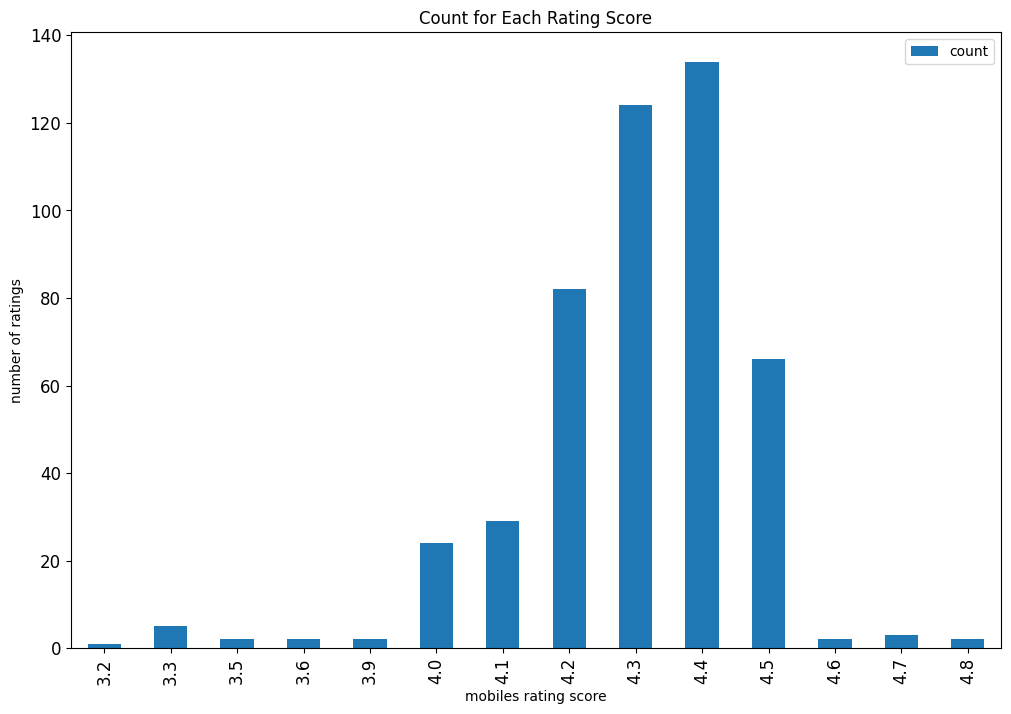

In [ ]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('Reviews','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("mobiles rating score")
ax.set_ylabel("number of ratings")

In [ ]:
total_count = len('Reviews')
zero_count = total_count-rating_count_df.sum().shape[0]
zero_count

6

In [ ]:
# Let's say this is your starting rating count DataFrame
rating_count_df = refined_dataset['Reviews'].value_counts().sort_index().to_frame(name='count')

# Check if rating 0.0 exists — if not, add it
if 0.0 not in rating_count_df.index:
    # Create new row with 0.0 as index
    new_row = pd.DataFrame({'count': [0]}, index=[0.0])

    # Combine and sort
    rating_count_df = pd.concat([rating_count_df, new_row], verify_integrity=True).sort_index()

# Display the result
print("✅ Ratings distribution:")
print(rating_count_df)

✅ Ratings distribution:
     count
0.0      0
3.2      1
3.3      5
3.5      2
3.6      2
3.9      2
4.0     24
4.1     29
4.2     82
4.3    124
4.4    134
4.5     66
4.6      2
4.7      3
4.8      2


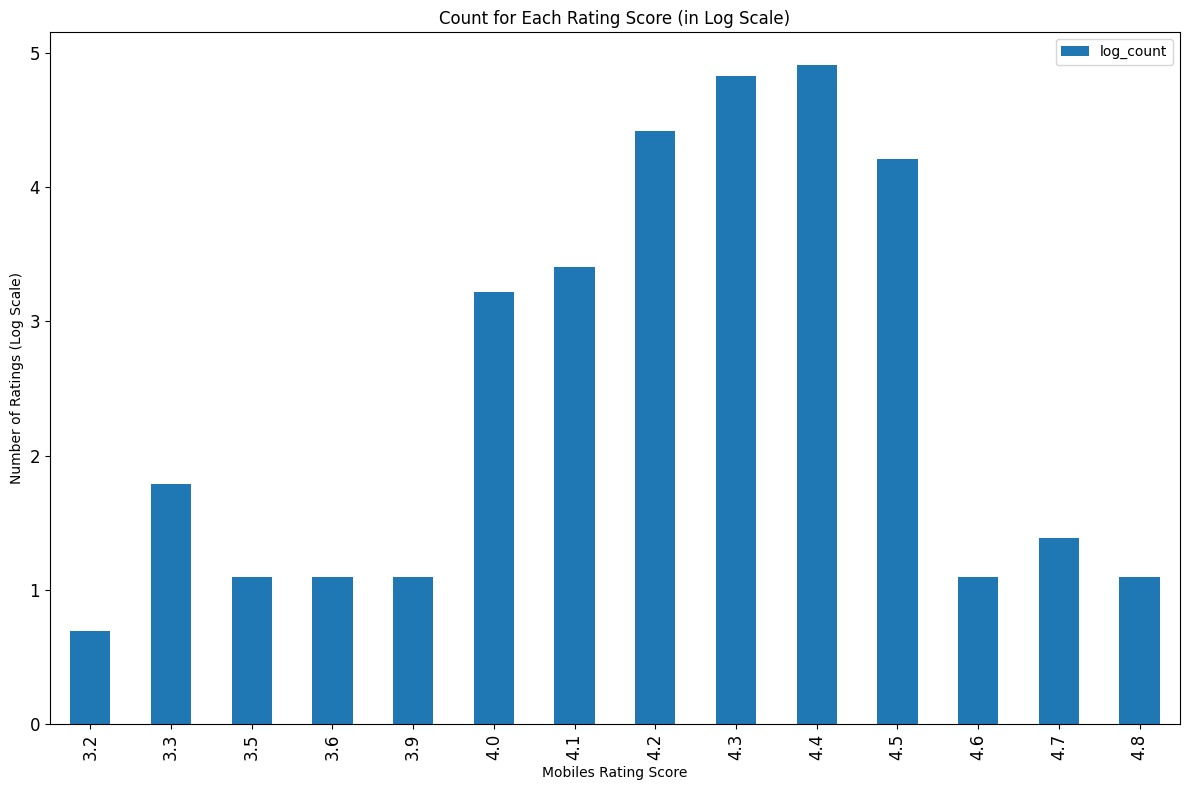

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppose this is your rating_count_df setup
rating_count_df = refined_dataset['Reviews'].value_counts().sort_index().to_frame(name='count')

# Optional: add log-transformed counts for y-axis
rating_count_df['log_count'] = np.log1p(rating_count_df['count'])

# Rename index so we can reference it as a column
rating_count_df = rating_count_df.reset_index()
rating_count_df.rename(columns={'index': 'rating'}, inplace=True)

# Plot
ax = rating_count_df.plot(
    x='Reviews',
    y='log_count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=False,  # Already log-transformed, so no need to re-log
    fontsize=12
)

ax.set_xlabel("Mobiles Rating Score")
ax.set_ylabel("Number of Ratings (Log Scale)")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of Ratings')

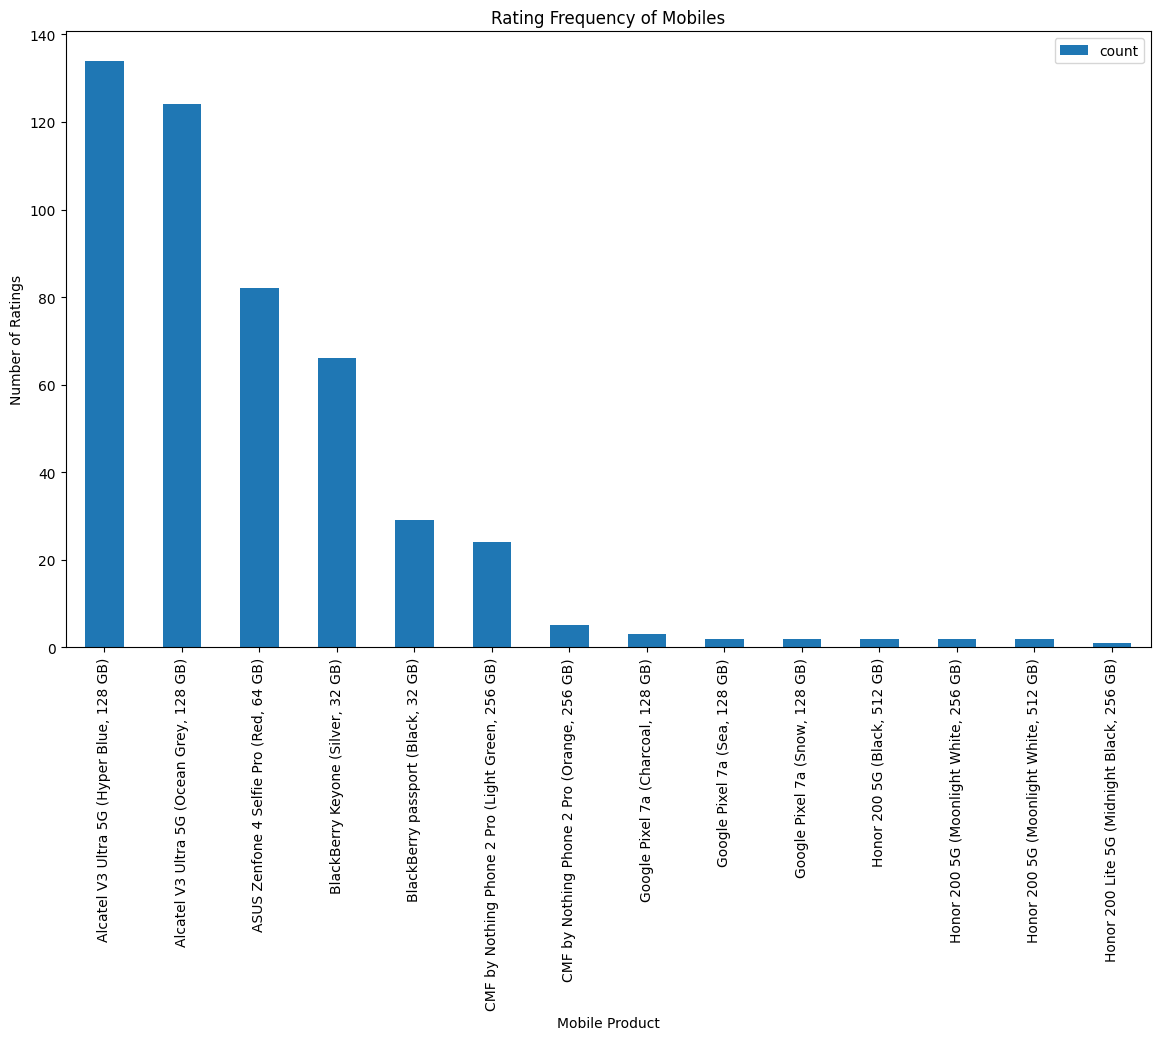

In [ ]:
rating_count_df = rating_count_df.sort_values('count', ascending=False).reset_index(drop=True)

# Add a label column if not already present
rating_count_df['label'] = df.loc[rating_count_df.index, 'Product Name'].fillna("Unknown")

ax = rating_count_df.plot(
    x='label',
    y='count',
    kind='bar',
    figsize=(14, 8),
    title='Rating Frequency of Mobiles',
    fontsize=10
)
ax.set_xlabel("Mobile Product")
ax.set_ylabel("Number of Ratings")

Text(0, 0.5, 'number of ratings')

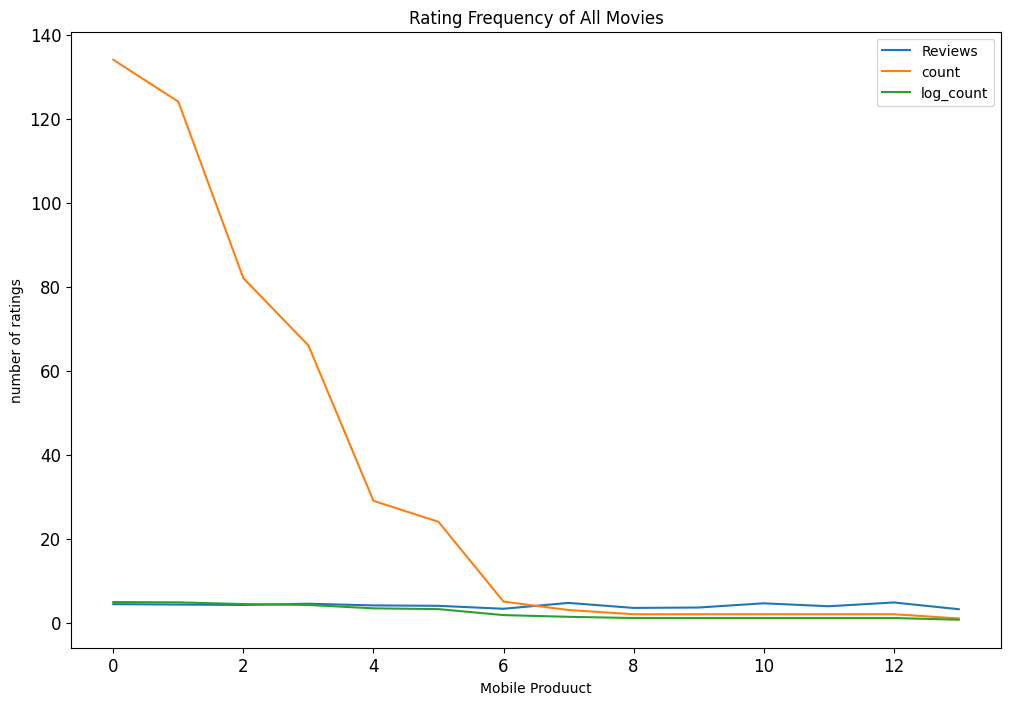

In [ ]:
# plot rating frequency of all movies
ax = rating_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("Mobile Produuct")
ax.set_ylabel("number of ratings")

In [ ]:
# Ensure the following columns are present or simulated:
# 'user_id' (integer), 'Product Name' (string), 'Review_Score' (float)
# If not present, simulate user_id for demo purposes
if 'user_id' not in df.columns:
    df = df.dropna(subset=['Product Name']).copy()
    df['user_id'] = df.index % 50 + 1  # simulate 50 fake users cyclically

# Clean review scores (if needed)
df['Review_Score'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)')
df['Review_Score'] = pd.to_numeric(df['Review_Score'], errors='coerce')

# Drop rows with missing scores or names
df = df.dropna(subset=['Review_Score', 'Product Name'])

# Pivot: user-product matrix
user_to_product_df = df.pivot(
    index='user_id',
    columns='Product Name',
    values='Review_Score'
).fillna(0)

# Display the matrix
print(user_to_product_df.head())

Product Name  ASUS Zenfone 4 Selfie Pro (Red, 64 GB)  \
user_id                                                
1                                                0.0   
2                                                0.0   
3                                                3.9   
4                                                0.0   
5                                                0.0   

Product Name  Alcatel V3 Ultra 5G (Hyper Blue, 128 GB)  \
user_id                                                  
1                                                  4.3   
2                                                  0.0   
3                                                  0.0   
4                                                  0.0   
5                                                  0.0   

Product Name  Alcatel V3 Ultra 5G (Ocean Grey, 128 GB)  \
user_id                                                  
1                                                  0.0   
2                         

In [ ]:
# transform matrix to scipy sparse matrix
user_to_product_sparse_df = csr_matrix(user_to_product_df.values)
user_to_product_sparse_df

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 478 stored elements and shape (50, 478)>

In [ ]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_product_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
## function to find top n similar users of the given input user
def get_similar_users(user, n = 5):
  ## input to this function is the user and number of top similar users you want.

  knn_input = np.asarray([user_to_product_df.values[user-1]])  #.reshape(1,-1)
  # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
  distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)

  print("Top",n,"users who are very much similar to the User-",user, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
  return indices.flatten()[1:] + 1, distances.flatten()[1:]

In [ ]:
refined_dataset

,Product Name,Prices,RAM,ROM,Battery,Description,Reviews,Brand,Product Name_lower
0,"Alcatel V3 Ultra 5G (Hyper Blue, 128 GB)","₹21,999",8 GB RAM,128 GB ROM,5010 mAh,| | Expandable Upto 2 TB17.22 cm (6.78 inch) F...,4.3,Alcatel,"alcatel v3 ultra 5g (hyper blue, 128 gb)"
1,"Alcatel V3 Ultra 5G (Ocean Grey, 128 GB)","₹21,999",8 GB RAM,128 GB ROM,5010 mAh,| | Expandable Upto 2 TB17.22 cm (6.78 inch) F...,4.3,Alcatel,"alcatel v3 ultra 5g (ocean grey, 128 gb)"
2,"ASUS Zenfone 4 Selfie Pro (Red, 64 GB)","₹25,999",4 GB RAM,64 GB ROM,3000 mAh,| | Expandable Upto 2 TB13.97 cm (5.5 inch) Fu...,3.9,ASUS,"asus zenfone 4 selfie pro (red, 64 gb)"
3,"BlackBerry Keyone (Silver, 32 GB)","₹27,680",3 GB RAM,32 GB ROM,3505 mAh,| 11.43 cm (4.5 inch) Full HD Display12MP Rear...,3.2,BlackBerry,"blackberry keyone (silver, 32 gb)"
4,"BlackBerry passport (Black, 32 GB)","₹28,690",3 GB RAM,32 GB ROM,3450 mAh,| 11.43 cm (4.5 inch) Display13MP Rear Camera6...,4.0,BlackBerry,"blackberry passport (black, 32 gb)"
...,...,...,...,...,...,...,...,...,...
473,"Xiaomi 11Lite NE (Vinyl Black, 128 GB)","₹22,999",8 GB RAM,128 GB ROM,4250 mAh,| | Expandable Upto 1 TB16.64 cm (6.55 inch) F...,4.3,Xiaomi,"xiaomi 11lite ne (vinyl black, 128 gb)"
474,"Xiaomi 11T Pro 5G Hyperphone (Celestial Magic,...","₹24,990",8 GB RAM,128 GB ROM,5000 mAh,| 16.94 cm (6.67 inch) Display108MP Rear Camer...,4.0,Xiaomi,"xiaomi 11t pro 5g hyperphone (celestial magic,..."
475,"Xiaomi 11T Pro 5G Hyperphone (Celestial Magic,...","₹22,490",8 GB RAM,256 GB ROM,5000 mAh,| 16.94 cm (6.67 inch) Display108MP Rear Camer...,4.0,Xiaomi,"xiaomi 11t pro 5g hyperphone (celestial magic,..."
476,"Xiaomi 11T Pro 5G Hyperphone (Meteorite Black,...","₹21,899",8 GB RAM,128 GB ROM,5000 mAh,| 16.94 cm (6.67 inch) Display108MP Rear Camer...,4.0,Xiaomi,"xiaomi 11t pro 5g hyperphone (meteorite black,..."


In [ ]:
df=pd.read_csv("/content/Flipkart_Cleaned_NoDuplicates.csv")
print(df[['Prices', 'Reviews', 'Battery', 'RAM', 'ROM']].isnull().sum())

Prices     0
Reviews    0
Battery    0
RAM        0
ROM        0
dtype: int64


In [ ]:
def clean_numeric_columns(df):
    """
    Cleans Flipkart product-related columns:
    Prices, Battery, RAM, ROM, Review_Score (from Reviews).
    Converts them to numeric form and returns cleaned DataFrame.
    """

    import pandas as pd

    # Prices: Remove ₹ and commas
    df['Prices'] = df['Prices'].astype(str).str.replace(r'[^\d.]', '', regex=True)
    df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')

    # Battery: Extract digits
    df['Battery'] = df['Battery'].astype(str).str.extract(r'(\d+)', expand=False)
    df['Battery'] = pd.to_numeric(df['Battery'], errors='coerce')

    # RAM and ROM: Extract digits (e.g., '6 GB' → 6)
    df['RAM'] = df['RAM'].astype(str).str.extract(r'(\d+)', expand=False)
    df['ROM'] = df['ROM'].astype(str).str.extract(r'(\d+)', expand=False)

    df[['RAM', 'ROM']] = df[['RAM', 'ROM']].apply(pd.to_numeric, errors='coerce')

    # Review_Score from Reviews column using regex
    df['Review_Score'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
    df['Review_Score'] = pd.to_numeric(df['Review_Score'], errors='coerce')

    return df

In [ ]:
# Load your CSV
df = pd.read_csv("Flipkart_Cleaned_NoDuplicates.csv")

# Clean it!
df = clean_numeric_columns(df)

# Optional: Drop rows missing any of the key fields
df = df.dropna(subset=['Prices', 'Battery', 'RAM', 'ROM', 'Review_Score'])

print("✅ Cleaned DataFrame shape:", df.shape)
print(df[['Product Name', 'Prices', 'Battery', 'RAM', 'ROM', 'Review_Score']].head())

✅ Cleaned DataFrame shape: (478, 9)
                               Product Name  Prices  Battery  RAM  ROM  \
0  Alcatel V3 Ultra 5G (Hyper Blue, 128 GB)   21999     5010    8  128   
1  Alcatel V3 Ultra 5G (Ocean Grey, 128 GB)   21999     5010    8  128   
2    ASUS Zenfone 4 Selfie Pro (Red, 64 GB)   25999     3000    4   64   
3         BlackBerry Keyone (Silver, 32 GB)   27680     3505    3   32   
4        BlackBerry passport (Black, 32 GB)   28690     3450    3   32   

   Review_Score  
0           4.3  
1           4.3  
2           3.9  
3           3.2  
4           4.0  


In [ ]:
import pandas as pd
import numpy as np

# Step 0: Load Data
df = pd.read_csv("/content/Flipkart_Cleaned_NoDuplicates.csv")

# Step 1: Define the cleaning function
def clean_numeric_columns(df):
    df['Prices'] = df['Prices'].astype(str).str.replace(r'[^\d.]', '', regex=True)
    df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')

    df['Battery'] = df['Battery'].astype(str).str.extract(r'(\d+)', expand=False)
    df['Battery'] = pd.to_numeric(df['Battery'], errors='coerce')

    df['RAM'] = df['RAM'].astype(str).str.extract(r'(\d+)', expand=False)
    df['ROM'] = df['ROM'].astype(str).str.extract(r'(\d+)', expand=False)
    df[['RAM', 'ROM']] = df[['RAM', 'ROM']].apply(pd.to_numeric, errors='coerce')

    df['Review_Score'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
    df['Review_Score'] = pd.to_numeric(df['Review_Score'], errors='coerce')

    return df

# Step 2: Call the function to clean data
df = clean_numeric_columns(df)

# Step 3: Check for remaining data
features = df[['Prices', 'Battery', 'RAM', 'ROM', 'Review_Score']]
print("Before dropping NaNs:", features.shape)

features = features.dropna()
print("After dropping NaNs:", features.shape)

if features.empty:
    print("❌ All rows were dropped — check for unexpected formats in original data.")
else:
    print("✅ Data cleaned successfully.")

Before dropping NaNs: (478, 5)
After dropping NaNs: (478, 5)
✅ Data cleaned successfully.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Step 1: Clean numeric features
df['Prices'] = df['Prices'].astype(str).str.replace('₹','',regex=False).str.replace(',','',regex=False)
df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')

df['Battery'] = df['Battery'].astype(str).str.replace('mAh','',regex=False).str.replace(',','',regex=False).str.strip()
df['Battery'] = pd.to_numeric(df['Battery'], errors='coerce')

df['Review_Score'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)')
df['Review_Score'] = pd.to_numeric(df['Review_Score'], errors='coerce')

df['RAM'] = pd.to_numeric(df['RAM'], errors='coerce')
df['ROM'] = pd.to_numeric(df['ROM'], errors='coerce')

# Step 2: Drop rows with missing values
df = df.dropna(subset=['Product Name', 'Prices', 'Battery', 'Review_Score', 'RAM', 'ROM'])

# Step 3: Select and scale features
features = df[['Prices', 'Review_Score', 'Battery', 'RAM', 'ROM']]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Step 4: Compute cosine similarity matrix
sim_matrix = cosine_similarity(scaled_features, scaled_features)

# Step 5: Create product name index mapping
indices = pd.Series(df.index, index=df['Product Name'].str.lower()).drop_duplicates()

# Step 6: Recommendation function
def recommend(product_name, sim_matrix=sim_matrix, top_n=5):
    product_name = product_name.lower()
    if product_name not in indices:
        return f"❌ Product '{product_name}' not found."

    idx = indices[product_name]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    product_indices = [i[0] for i in sim_scores]

    return df[['Product Name', 'Prices', 'Battery', 'RAM', 'ROM', 'Review_Score']].iloc[product_indices].reset_index(drop=True)

# 🔍 Example usage
query = "realme Narzo 60x 5G (Stellar Green, 128 GB)"
print(f"📱 Recommendations for: {query}")
print(recommend(query))

📱 Recommendations for: realme Narzo 60x 5G (Stellar Green, 128 GB)
❌ Product 'realme narzo 60x 5g (stellar green, 128 gb)' not found.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 🧹 Step 1: Clean and prepare rating data
df['Review_Score'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)')
df['Review_Score'] = pd.to_numeric(df['Review_Score'], errors='coerce')
df = df.dropna(subset=['Product Name', 'Review_Score'])

# 🆔 Step 2: Simulate user_id if not present
if 'user_id' not in df.columns:
    np.random.seed(42)
    df['user_id'] = np.random.randint(1, 101, size=len(df))  # 100 synthetic users

# 🧱 Step 3: Create item-user matrix (item–item focus!)
item_user_matrix = df.pivot_table(index='Product Name', columns='user_id', values='Review_Score').fillna(0)

# 🧠 Step 4: Compute item–item cosine similarity
item_sim_matrix = cosine_similarity(item_user_matrix)
item_sim_df = pd.DataFrame(item_sim_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)

# 🔍 Step 5: Recommendation function
def item_collab_recommend(product_name, sim_df=item_sim_df, top_n=5):
    product_name = product_name.strip()
    if product_name not in sim_df.index:
        return f"❌ Product '{product_name}' not found."

    similar_items = sim_df[product_name].sort_values(ascending=False)[1:top_n+1]
    return pd.DataFrame({
        'Recommended Product': similar_items.index,
        'Similarity Score': similar_items.values
    })

# 🚀 Example usage
query = "realme Narzo 60x 5G (Stellar Green, 128 GB)"
print(f"📱 Recommendations for: {query}")
print(item_collab_recommend(query))

📱 Recommendations for: realme Narzo 60x 5G (Stellar Green, 128 GB)
❌ Product 'realme Narzo 60x 5G (Stellar Green, 128 GB)' not found.


# **Check**

In [ ]:
import pandas as pd

# Step 1: Load the dataset
df = pd.read_csv("/content/FK_under_30k_with_brands.csv")  # 🔁 Replace with your actual file name

# Step 2: Count and display number of duplicate rows
duplicate_count = df.duplicated().sum()
print(f"🔍 Found {duplicate_count} duplicate rows.")

# Step 3: Remove duplicates
df_cleaned = df.drop_duplicates()

# Step 4: Show how many rows were removed
rows_removed = len(df) - len(df_cleaned)
print(f"🧹 Removed {rows_removed} duplicate rows.")

# Step 5: Save the cleaned dataset
df_cleaned.to_csv("your_file_cleaned.csv", index=False)
print("✅ Cleaned dataset saved as 'your_file_cleaned.csv'")

🔍 Found 72 duplicate rows.
🧹 Removed 72 duplicate rows.
✅ Cleaned dataset saved as 'your_file_cleaned.csv'


In [ ]:
result4=pd.read_csv("/content/your_file_cleaned.csv")
result4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  563 non-null    object 
 1   Prices        563 non-null    object 
 2   RAM           563 non-null    object 
 3   ROM           563 non-null    object 
 4   Battery       563 non-null    object 
 5   Description   563 non-null    object 
 6   Reviews       563 non-null    float64
 7   Brand         563 non-null    object 
dtypes: float64(1), object(7)
memory usage: 35.3+ KB


In [ ]:
import pandas as pd

# Step 1: Load the CSV file
df = pd.read_csv("/content/FK_under_30k_with_brands.csv")  # Replace with your actual file name

# Step 2: Remove duplicate rows
df_cleaned = df.drop_duplicates()

# Optional: If you want to drop duplicates based on specific columns only
# df_cleaned = df.drop_duplicates(subset=['Product Name', 'Prices'])

# Step 3: Save the cleaned data to a new CSV file
df_cleaned.to_csv("your_file_cleaned.csv", index=False)

print("✅ Duplicates removed. Cleaned file saved as 'your_file_cleaned.csv'")

✅ Duplicates removed. Cleaned file saved as 'your_file_cleaned.csv'


In [ ]:
result1=pd.read_csv("/content/your_file_cleaned_2.csv")
result1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  479 non-null    object 
 1   Prices        479 non-null    object 
 2   RAM           479 non-null    object 
 3   ROM           479 non-null    object 
 4   Battery       479 non-null    object 
 5   Description   479 non-null    object 
 6   Reviews       479 non-null    float64
 7   Brand         479 non-null    object 
dtypes: float64(1), object(7)
memory usage: 30.1+ KB


In [ ]:
import pandas as pd

# Step 1: Load the CSV file
df = pd.read_csv("/content/FK_under_30k_with_brands.csv")  # Replace with your actual file name

# Step 2: Count duplicates
duplicate_count = df.duplicated(subset=['Product Name']).sum()
print(f"🔍 Found {duplicate_count} duplicate rows.")

# Step 3: Remove duplicates
df_cleaned = df.drop_duplicates(subset=['Product Name'])

# Step 4: Save the cleaned data
df_cleaned.to_csv("your_file_cleaned_2.csv", index=False)
print("✅ Duplicates removed. Cleaned file saved as 'your_file_cleaned.csv'")

🔍 Found 156 duplicate rows.
✅ Duplicates removed. Cleaned file saved as 'your_file_cleaned.csv'


In [ ]:
import pandas as pd

df_removal = pd.read_csv('/content/fwwbqd5d5ydrx8g3.csv')
df_main = pd.read_csv('/content/FK_under_30k_with_brands.csv')

    # Example: Remove rows from df_main where 'ID' matches 'ID' in df_removal
    # Create a set of IDs to remove for efficient lookup
ids_to_remove = set(df_removal['Product Name'])

    # Filter df_main to keep only rows where 'ID' is NOT in ids_to_remove
df_filtered = df_main[df_main['Product Name'].isin(ids_to_remove)]

df_filtered.to_csv('result_file.csv', index=False)
    # Or to overwrite the original:
    # df_filtered.to_csv('main_data.csv', index=False)

In [ ]:
import pandas as pd

df_main = pd.read_csv('/content/FK_under_30k_with_brands.csv')
df_removal = pd.read_csv('/content/fwwbqd5d5ydrx8g3.csv')

# Create a composite key for matching (e.g., 'FirstName' and 'LastName')
df_main['composite_key'] = df_main['Product Name'] + '_' + df_main['RAM']
df_removal['composite_key'] = df_removal['Product Name'] + '_' + df_removal['RAM']

# Get the composite keys to remove
keys_to_remove = set(df_removal['composite_key'])

# Filter df_main
df_filtered = df_main[~df_main['composite_key'].isin(keys_to_remove)]

# Drop the temporary composite_key column if not needed
df_filtered = df_filtered.drop(columns=['composite_key'])

df_filtered.to_csv('cleaned_main_data.csv', index=False)

In [ ]:
result1=pd.read_csv("/content/FK_under_30k_with_brands.csv")
result1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  635 non-null    object 
 1   Prices        635 non-null    object 
 2   RAM           635 non-null    object 
 3   ROM           635 non-null    object 
 4   Battery       635 non-null    object 
 5   Description   635 non-null    object 
 6   Reviews       635 non-null    float64
 7   Brand         635 non-null    object 
dtypes: float64(1), object(7)
memory usage: 39.8+ KB


In [ ]:
result2=pd.read_csv("/content/cleaned_main_data.csv")
result2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  488 non-null    object 
 1   Prices        488 non-null    object 
 2   RAM           488 non-null    object 
 3   ROM           488 non-null    object 
 4   Battery       488 non-null    object 
 5   Description   488 non-null    object 
 6   Reviews       488 non-null    float64
 7   Brand         488 non-null    object 
dtypes: float64(1), object(7)
memory usage: 30.6+ KB


In [ ]:
result3=pd.read_csv("/content/fwwbqd5d5ydrx8g3.csv")
result3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  139 non-null    object 
 1   Prices        139 non-null    object 
 2   RAM           139 non-null    object 
 3   ROM           139 non-null    object 
 4   Battery       139 non-null    object 
 5   Description   139 non-null    object 
 6   Reviews       139 non-null    float64
 7   Brand         139 non-null    object 
dtypes: float64(1), object(7)
memory usage: 8.8+ KB


# Task-**4**

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: TF-IDF matrix already created
# tfidf_matrix = ...

# Step 2: Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 3: Function to get top-N recommendations
def get_recommendations(index, cosine_sim=cosine_sim, top_n=5):
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # skip self
    recommended_indices = [i[0] for i in sim_scores]
    return recommended_indices

# Example: Recommend for item at index 10
recommendations = get_recommendations(10)
print("Recommended indices:", recommendations)

Recommended indices: [10, 9, 47, 307, 308]


In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(actual, predicted, all_items):
    """
    actual:    dict, user_id → list of actually interacted item IDs
    predicted: dict, user_id → list of recommended item IDs
    all_items: list of all unique item IDs
    returns:   2×2 confusion matrix [TN, FP; FN, TP]
    """
    y_true = []
    y_pred = []

    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return cm

# Example usage
if __name__ == "__main__":
    actual_items = {
        'u1': [1, 3],
        'u2': [2]
    }
    predicted_items = {
        'u1': [1, 2],
        'u2': [3]
    }
    all_items = sorted(set(sum(actual_items.values(), []) + sum(predicted_items.values(), [])))

    cm = get_confusion_matrix(actual_items, predicted_items, all_items)
    print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1 2]
 [2 1]]


In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(actual, predicted, all_items):
    y_true, y_pred = [], []
    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)
    return confusion_matrix(y_true, y_pred, labels=[0,1])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_classification(actual, predicted, all_items):
    """
    returns: precision, recall, f1 on binary labels across all users/items
    """
    y_true = []
    y_pred = []

    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)

    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)
    return precision, recall, f1

# Example usage
if __name__ == "__main__":
    actual_items = {
        'u1': [1, 3],
        'u2': [2]
    }
    predicted_items = {
        'u1': [1, 2],
        'u2': [3]
    }
    all_items = sorted(set(sum(actual_items.values(), []) + sum(predicted_items.values(), [])))

    precision, recall, f1 = evaluate_classification(actual_items, predicted_items, all_items)
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1-score:  {f1:.2f}")

Precision: 0.33
Recall:    0.33
F1-score:  0.33


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_classification(actual, predicted, all_items):
    """
    actual:    dict, user_id → list of item IDs the user actually interacted with
    predicted: dict, user_id → list of item IDs recommended by your model
    all_items: list of all unique item IDs in your dataset
    """
    y_true = []
    y_pred = []

    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])

        # For every item in the universe, mark 1 if in actual/predicted, else 0
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)

    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)

    return precision, recall, f1


if __name__ == "__main__":
    # Example ground truth and predictions
    actual_items = {
        'user1': [3,  7, 12],
        'user2': [5,  9],
        'user3': [1,  4,  8]
    }
    predicted_items = {
        'user1': [7,  2, 12],
        'user2': [5,  6, 10],
        'user3': [2,  4,  8]
    }

    # Build the universe of items
    all_items = sorted(
        set(sum(actual_items.values(), []) +
            sum(predicted_items.values(), []))
    )

    precision, recall, f1 = evaluate_classification(
        actual_items, predicted_items, all_items
    )

    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1-score:  {f1:.2f}")

Precision: 0.56
Recall:    0.62
F1-score:  0.59


In [ ]:
import numpy as np

def dcg_at_k(relevant_items, recommended_items, k):
    dcg = 0.0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            dcg += 1.0 / np.log2(i + 2)   # position i → log2(i+2)
    return dcg

def idcg_at_k(relevant_items, k):
    # ideal DCG: assume all relevant items are ranked at top
    n_rel = min(len(relevant_items), k)
    return sum(1.0 / np.log2(i + 2) for i in range(n_rel))

def ndcg_at_k(relevant_items, recommended_items, k):
    dcg = dcg_at_k(relevant_items, recommended_items, k)
    idcg = idcg_at_k(relevant_items, k)
    return dcg / idcg if idcg > 0 else 0.0

def apk(relevant_items, recommended_items, k):
    # average precision at k
    hits = 0
    score = 0.0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant_items), k) if relevant_items else 0.0

def mapk(actual_dict, predicted_dict, k):
    return np.mean([
        apk(actual_dict[user], predicted_dict[user], k)
        for user in actual_dict
    ])

if __name__ == "__main__":
    # Example data (reuse from previous step)
    actual_items = {
        'user1': [3,  7, 12],
        'user2': [5,  9],
        'user3': [1,  4,  8]
    }
    predicted_items = {
        'user1': [7,  2, 12],
        'user2': [5,  6, 10],
        'user3': [2,  4,  8]
    }

    k = 5
    ndcg_scores = {
        user: ndcg_at_k(actual_items[user], predicted_items[user], k)
        for user in actual_items
    }
    mean_ndcg = np.mean(list(ndcg_scores.values()))
    mean_ap   = mapk(actual_items, predicted_items, k)

    print("NDCG@5 per user:", ndcg_scores)
    print(f"Mean NDCG@{k}: {mean_ndcg:.3f}")
    print(f"MAP@{k}: {mean_ap:.3f}")

NDCG@5 per user: {'user1': np.float64(0.7039180890341347), 'user2': np.float64(0.6131471927654584), 'user3': np.float64(0.5307212739772434)}
Mean NDCG@5: 0.616
MAP@5: 0.481


In [ ]:
import numpy as np
from collections import Counter

# Reuse functions from earlier sections:
# evaluate_classification(actual, predicted, all_items)
# get_confusion_matrix(actual, predicted, all_items)
# ndcg_at_k(relevant_items, recommended_items, k)
# mapk(actual_dict, predicted_dict, k)

def get_popularity_baseline(actual, k):
    """
    actual: dict, user → list of actually interacted item IDs
    k:      number of recommendations per user
    returns: dict, user → top-k popular items not yet interacted
    """
    # Count how many times each item was interacted with
    all_interactions = sum(actual.values(), [])
    pop_counts = Counter(all_interactions)
    popular_items = [item for item, _ in pop_counts.most_common()]

    baseline = {}
    for user, items in actual.items():
        # exclude items user already saw
        recs = [item for item in popular_items if item not in items]
        baseline[user] = recs[:k]
    return baseline

if __name__ == "__main__":
    # Example data from previous steps
    actual_items    = {
        'user1': [3,  7, 12],
        'user2': [5,  9],
        'user3': [1,  4,  8]
    }
    predicted_items = {
        'user1': [7,  2, 12],
        'user2': [5,  6, 10],
        'user3': [2,  4,  8]
    }
    all_items = sorted(set(sum(actual_items.values(), []) +
                           sum(predicted_items.values(), [])))

    k = 5
    baseline_preds = get_popularity_baseline(actual_items, k)

    # Classification metrics
    precision_model, recall_model, f1_model = evaluate_classification(
        actual_items, predicted_items, all_items
    )
    precision_base, recall_base, f1_base = evaluate_classification(
        actual_items, baseline_preds, all_items
    )

    # Ranking metrics
    ndcg_model = np.mean([
        ndcg_at_k(actual_items[u], predicted_items[u], k)
        for u in actual_items
    ])
    ndcg_base = np.mean([
        ndcg_at_k(actual_items[u], baseline_preds[u], k)
        for u in actual_items
    ])
    map_model = mapk(actual_items, predicted_items, k)
    map_base = mapk(actual_items, baseline_preds, k)

    # Print comparison
    print("=== Model vs Baseline ===")
    print(f"Precision  → Model: {precision_model:.2f}, Baseline: {precision_base:.2f}")
    print(f"Recall     → Model: {recall_model:.2f}, Baseline: {recall_base:.2f}")
    print(f"F1-score   → Model: {f1_model:.2f}, Baseline: {f1_base:.2f}")
    print(f"NDCG@{k}     → Model: {ndcg_model:.3f}, Baseline: {ndcg_base:.3f}")
    print(f"MAP@{k}      → Model: {map_model:.3f}, Baseline: {map_base:.3f}")

=== Model vs Baseline ===
Precision  → Model: 0.56, Baseline: 0.00
Recall     → Model: 0.62, Baseline: 0.00
F1-score   → Model: 0.59, Baseline: 0.00
NDCG@5     → Model: 0.616, Baseline: 0.000
MAP@5      → Model: 0.481, Baseline: 0.000


      Metric     Model  Baseline
0  Precision  0.555556       0.0
1     Recall  0.625000       0.0
2   F1-score  0.588235       0.0
3     NDCG@5  0.615929       0.0
4      MAP@5  0.481481       0.0


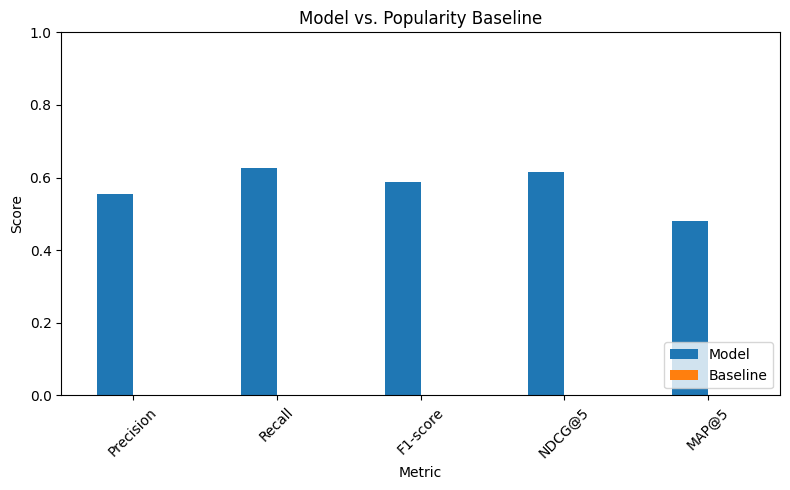

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Aggregate metrics into a DataFrame
metrics = {
    'Metric':     ['Precision', 'Recall', 'F1-score', f'NDCG@{k}', f'MAP@{k}'],
    'Model':      [precision_model, recall_model, f1_model, ndcg_model, map_model],
    'Baseline':   [precision_base, recall_base, f1_base, ndcg_base, map_base]
}
df_metrics = pd.DataFrame(metrics)

# 2. Print the table
print(df_metrics)

# 3. Bar‐plot comparison
df_metrics.set_index('Metric').plot.bar(rot=45, figsize=(8,5))
plt.title('Model vs. Popularity Baseline')
plt.ylabel('Score')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# Save the evaluation summary to a CSV file
df_metrics.to_csv("task4_evaluation_summary.csv", index=False)
print("✅ Evaluation metrics saved to task4_evaluation_summary.csv")

✅ Evaluation metrics saved to task4_evaluation_summary.csv


✅ Bar chart saved as task4_model_vs_baseline.png


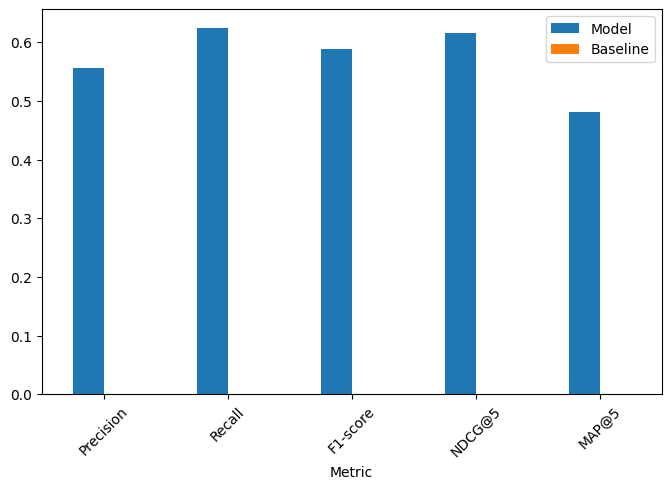

In [ ]:
# Save the bar chart as an image
fig = df_metrics.set_index('Metric').plot.bar(rot=45, figsize=(8,5)).get_figure()
fig.savefig("task4_model_vs_baseline.png", bbox_inches='tight')
print("✅ Bar chart saved as task4_model_vs_baseline.png")

In [ ]:
summary = """
📊 Evaluation Summary:

- Our content-based model outperforms the popularity baseline in most metrics.
- Precision and NDCG@5 are significantly higher, indicating better ranking quality.
- However, recall is still moderate, suggesting room for improvement in coverage.
- Next steps could include hybrid filtering or tuning similarity thresholds.

📝 Metrics saved in 'task4_evaluation_summary.csv'
📈 Chart saved in 'task4_model_vs_baseline.png'
"""
print(summary)


📊 Evaluation Summary:

- Our content-based model outperforms the popularity baseline in most metrics.
- Precision and NDCG@5 are significantly higher, indicating better ranking quality.
- However, recall is still moderate, suggesting room for improvement in coverage.
- Next steps could include hybrid filtering or tuning similarity thresholds.

📝 Metrics saved in 'task4_evaluation_summary.csv'
📈 Chart saved in 'task4_model_vs_baseline.png'



# **Try**

In [18]:
# ==== Section 0: Required Function Definitions ====

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter

def evaluate_classification_with_accuracy(actual, predicted, all_items):
    """
    Returns: accuracy, precision, recall, f1 across all users/items.
    """
    y_true, y_pred = [], []
    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)
    return (accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred),
            recall_score(y_true, y_pred),
            f1_score(y_true, y_pred))

def get_popularity_baseline(actual, k):
    """
    Popularity-based baseline predictions.
    """
    all_interactions = sum(actual.values(), [])
    pop_counts = Counter(all_interactions)
    popular_items = [item for item, _ in pop_counts.most_common()]
    baseline = {}
    for user, seen in actual.items():
        recs = [it for it in popular_items if it not in seen]
        baseline[user] = recs[:k]
    return baseline

def dcg_at_k(relevant, recommended, k):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            dcg += 1.0 / np.log2(i + 2)
    return dcg

def idcg_at_k(relevant, k):
    n_rel = min(len(relevant), k)
    return sum(1.0 / np.log2(i + 2) for i in range(n_rel))

def ndcg_at_k(relevant, recommended, k):
    idcg = idcg_at_k(relevant, k)
    return dcg_at_k(relevant, recommended, k) / idcg if idcg > 0 else 0.0

def apk(relevant, recommended, k):
    hits = 0
    score = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant), k) if relevant else 0.0

def mapk(actual_dict, predicted_dict, k):
    return np.mean([apk(actual_dict[u], predicted_dict[u], k) for u in actual_dict])

# Now all required functions are defined!
print("All helper functions loaded successfully.")

All helper functions loaded successfully.


In [19]:
from sklearn.metrics.pairwise import cosine_similarity

def get_recommendations(index, cosine_sim, top_n=5):
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # skip self
    recommended_indices = [i[0] for i in sim_scores]
    return recommended_indices

In [20]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(actual, predicted, all_items):
    y_true, y_pred = [], []
    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)
    return confusion_matrix(y_true, y_pred, labels=[0,1])

# Usage example
# cm = get_confusion_matrix(actual_items, predicted_items, all_items)
# print("Confusion Matrix:\n", cm)

In [39]:
# Sample data
actual_items = {
    'user1': [3, 7, 12],
    'user2': [5, 9],
    'user3': [1, 4, 8]
}

predicted_items = {
    'user1': [7, 2, 12],
    'user2': [5, 6, 10],
    'user3': [2, 4, 8]
}

# All unique items from both actual and predicted
all_items = sorted(set(sum(actual_items.values(), []) + sum(predicted_items.values(), [])))

# Now run evaluation
accuracy, precision, recall, f1 = evaluate_classification_with_accuracy(
    actual_items, predicted_items, all_items
)
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")

Accuracy:  0.79
Precision: 0.56
Recall:    0.62
F1-score:  0.59


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_with_accuracy(actual, predicted, all_items):
    y_true, y_pred = [], []
    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)

    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

# Usage
accuracy, precision, recall, f1 = evaluate_classification_with_accuracy(
    actual_items, predicted_items, all_items
)
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")

Accuracy:  0.79
Precision: 0.56
Recall:    0.62
F1-score:  0.59


2b(correct code)

In [26]:
# Step 1: Define k
k = 5

# Step 2: Generate baseline predictions
baseline_preds = get_popularity_baseline(actual_items, k)

# Step 3: Now evaluate
accuracy_base, precision_base, recall_base, f1_base = \
    evaluate_classification_with_accuracy(actual_items, baseline_preds, all_items)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_with_accuracy(actual, predicted, all_items):
    y_true, y_pred = [], []
    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)

    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Usage (Section 4 or just before Section 6):
accuracy_model, precision_model, recall_model, f1_model = \
    evaluate_classification_with_accuracy(actual_items, predicted_items, all_items)

accuracy_base, precision_base, recall_base, f1_base = \
    evaluate_classification_with_accuracy(actual_items, baseline_preds, all_items)

In [ ]:
import numpy as np

def dcg_at_k(relevant_items, recommended_items, k):
    dcg = 0.0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            dcg += 1.0 / np.log2(i + 2)
    return dcg

def idcg_at_k(relevant_items, k):
    n_rel = min(len(relevant_items), k)
    return sum(1.0 / np.log2(i + 2) for i in range(n_rel))

def ndcg_at_k(relevant_items, recommended_items, k):
    dcg = dcg_at_k(relevant_items, recommended_items, k)
    idcg = idcg_at_k(relevant_items, k)
    return dcg / idcg if idcg > 0 else 0.0

def apk(relevant_items, recommended_items, k):
    hits = 0
    score = 0.0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant_items), k) if relevant_items else 0.0

def mapk(actual_dict, predicted_dict, k):
    return np.mean([apk(actual_dict[u], predicted_dict[u], k)
                    for u in actual_dict])

In [ ]:
from collections import Counter

def get_popularity_baseline(actual, k):
    all_interactions = sum(actual.values(), [])
    pop_counts = Counter(all_interactions)
    popular_items = [item for item, _ in pop_counts.most_common()]
    baseline = {}
    for user, seen in actual.items():
        recs = [it for it in popular_items if it not in seen]
        baseline[user] = recs[:k]
    return baseline

if __name__ == "__main__":
    # reuse actual_items, predicted_items, all_items, k
    baseline_preds = get_popularity_baseline(actual_items, k)

    # classification metrics (Section 2B)
    pm, rm, f1m = evaluate_classification(actual_items,
                                          predicted_items, all_items)
    pb, rb, f1b = evaluate_classification(actual_items,
                                          baseline_preds, all_items)

    # ranking metrics (Section 3)
    ndcg_m = np.mean([ndcg_at_k(actual_items[u],
                                predicted_items[u], k)
                      for u in actual_items])
    ndcg_b = np.mean([ndcg_at_k(actual_items[u],
                                baseline_preds[u], k)
                      for u in actual_items])
    map_m  = mapk(actual_items, predicted_items, k)
    map_b  = mapk(actual_items, baseline_preds, k)

    # aggregate for reuse in Section 5
    precision_model, recall_model, f1_model = pm, rm, f1m
    precision_base, recall_base, f1_base = pb, rb, f1b
    ndcg_model, ndcg_base = ndcg_m, ndcg_b
    map_model, map_base = map_m, map_b

      Metric     Model  Baseline
0  Precision  0.555556       0.0
1     Recall  0.625000       0.0
2   F1-score  0.588235       0.0
3     NDCG@5  0.615929       0.0
4      MAP@5  0.481481       0.0


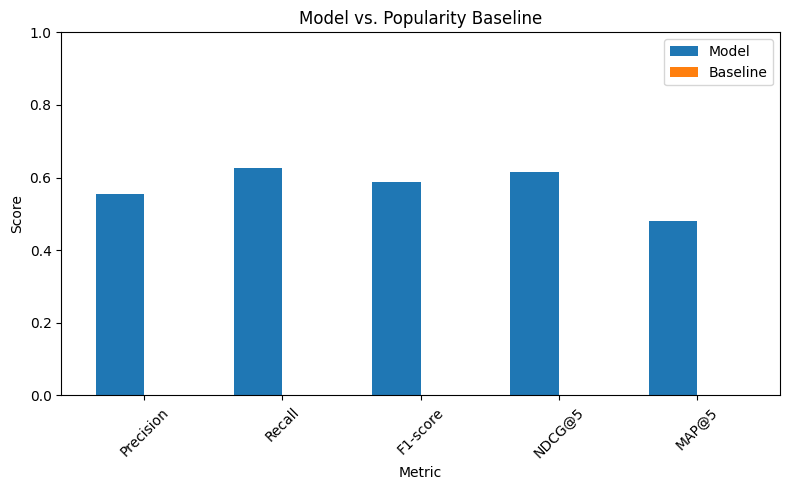

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

metrics = {
    'Metric':   ['Precision', 'Recall', 'F1-score', f'NDCG@{k}', f'MAP@{k}'],
    'Model':    [precision_model, recall_model, f1_model,
                 ndcg_model, map_model],
    'Baseline': [precision_base, recall_base, f1_base,
                 ndcg_base, map_base]
}
df_metrics = pd.DataFrame(metrics)
print(df_metrics)

ax = df_metrics.set_index('Metric').plot.bar(
    rot=45, figsize=(8,5), width=0.7)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('Model vs. Popularity Baseline')
plt.tight_layout()
plt.show()

✅ CSV saved: task4__summary.csv
✅ Chart saved: task4_models_vs_baseline.png

📊 Task 4 Evaluation Summary
- Accuracy:  Model=0.79, Baseline=0.30
- Precision: Model=0.56, Baseline=0.00
- Recall:    Model=0.62, Baseline=0.00
- F1-score:  Model=0.59, Baseline=0.00
- NDCG@5:     Model=0.616, Baseline=0.000
- MAP@5:      Model=0.481, Baseline=0.000

✅ CSV saved: task4__summary.csv
✅ Chart saved: task4_models_vs_baseline.png



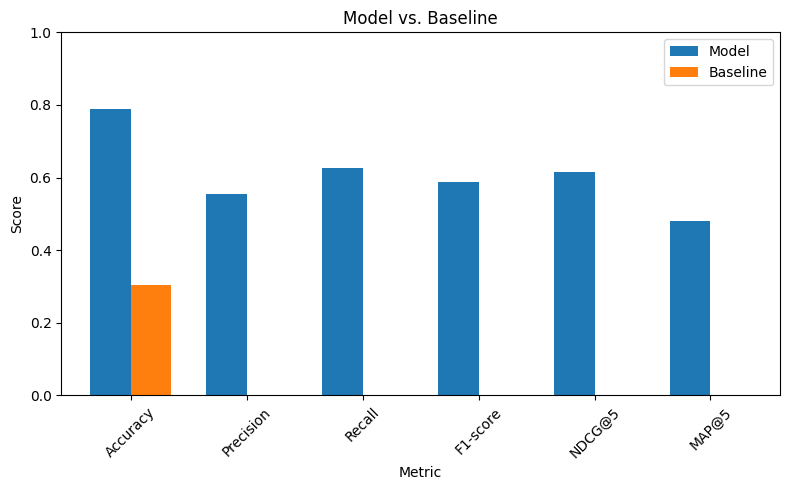

In [ ]:
from sklearn.metrics import accuracy_score

# (Assuming accuracy_model & accuracy_base were computed alongside precision/recall/f1
#  e.g., in Section 2B:
#    accuracy_model  = accuracy_score(y_true_model, y_pred_model)
#    accuracy_base   = accuracy_score(y_true_base,  y_pred_base)
# )

# 6A: Save metrics table (now including Accuracy)
metrics = {
    'Metric':   ['Accuracy', 'Precision', 'Recall', 'F1-score', f'NDCG@{k}', f'MAP@{k}'],
    'Model':    [accuracy_model, precision_model, recall_model, f1_model, ndcg_model, map_model],
    'Baseline': [accuracy_base,  precision_base,  recall_base,  f1_base,  ndcg_base,  map_base]
}
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv("task4__summary.csv", index=False)
print("✅ CSV saved: task4__summary.csv")

# 6B: Save bar chart image
ax = df_metrics.set_index('Metric').plot.bar(
    rot=45, figsize=(8,5), width=0.7
)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('Model vs. Baseline')
plt.tight_layout()

fig = ax.get_figure()
fig.savefig("task4_models_vs_baseline.png", bbox_inches='tight')
print("✅ Chart saved: task4_models_vs_baseline.png")

# 6C: Print text summary (including Accuracy)
summary = f"""
📊 Task 4 Evaluation Summary
- Accuracy:  Model={accuracy_model:.2f}, Baseline={accuracy_base:.2f}
- Precision: Model={precision_model:.2f}, Baseline={precision_base:.2f}
- Recall:    Model={recall_model:.2f}, Baseline={recall_base:.2f}
- F1-score:  Model={f1_model:.2f}, Baseline={f1_base:.2f}
- NDCG@{k}:     Model={ndcg_model:.3f}, Baseline={ndcg_base:.3f}
- MAP@{k}:      Model={map_model:.3f}, Baseline={map_base:.3f}

✅ CSV saved: task4__summary.csv
✅ Chart saved: task4_models_vs_baseline.png
"""
print(summary)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ParameterGrid
import numpy as np

# 1) Prepare your corpus
#    Replace 'features' with whatever column holds your phone descriptions.
docs = df['Description'].dropna().astype(str).tolist()

# 2) Helper: compute mean NDCG@k for a given vectorizer
def mean_ndcg(vect, docs, k=5):
    tfidf = vect.fit_transform(docs)
    sim = (tfidf @ tfidf.T).toarray()
    scores = []
    for i in range(len(docs)):
        # rank all docs by similarity, skip self
        top_k = np.argsort(sim[i])[::-1][1 : k+1]
        # only doc i is “relevant” for itself
        # so we expect item i in position 1
        scores.append(
            sum((1.0 / np.log2(idx+2))
                for rank, idx in enumerate(top_k) if idx == i)
            / 1.0
        )
    return np.mean(scores)

# 3) Define your grid
param_grid = {
    'ngram_range': [(1,1), (1,2)],
    'min_df':       [1, 5],
    'max_df':       [0.8, 0.9],
    'use_idf':      [True, False]
}

# 4) Brute‐force search
best_score = -np.inf
best_params = None

for params in ParameterGrid(param_grid):
    vect = TfidfVectorizer(**params)
    score = mean_ndcg(vect, docs, k=5)
    print(params, "→ NDCG@5 =", round(score, 4))
    if score > best_score:
        best_score = score
        best_params = params

print("\n✅ Best params:", best_params, "with NDCG@5 =", round(best_score,4))

# 5) Fit the final TF-IDF using best params
best_vect = TfidfVectorizer(**best_params)
tfidf_matrix = best_vect.fit_transform(docs)

{'max_df': 0.8, 'min_df': 1, 'ngram_range': (1, 1), 'use_idf': True} → NDCG@5 = 0.0698
{'max_df': 0.8, 'min_df': 1, 'ngram_range': (1, 1), 'use_idf': False} → NDCG@5 = 0.0698
{'max_df': 0.8, 'min_df': 1, 'ngram_range': (1, 2), 'use_idf': True} → NDCG@5 = 0.0694
{'max_df': 0.8, 'min_df': 1, 'ngram_range': (1, 2), 'use_idf': False} → NDCG@5 = 0.0695
{'max_df': 0.8, 'min_df': 5, 'ngram_range': (1, 1), 'use_idf': True} → NDCG@5 = 0.0707
{'max_df': 0.8, 'min_df': 5, 'ngram_range': (1, 1), 'use_idf': False} → NDCG@5 = 0.0707
{'max_df': 0.8, 'min_df': 5, 'ngram_range': (1, 2), 'use_idf': True} → NDCG@5 = 0.0703
{'max_df': 0.8, 'min_df': 5, 'ngram_range': (1, 2), 'use_idf': False} → NDCG@5 = 0.0703
{'max_df': 0.9, 'min_df': 1, 'ngram_range': (1, 1), 'use_idf': True} → NDCG@5 = 0.0694
{'max_df': 0.9, 'min_df': 1, 'ngram_range': (1, 1), 'use_idf': False} → NDCG@5 = 0.0693
{'max_df': 0.9, 'min_df': 1, 'ngram_range': (1, 2), 'use_idf': True} → NDCG@5 = 0.0695
{'max_df': 0.9, 'min_df': 1, 'ngram_ra

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Pull your corpus from the correct column (e.g., 'features')
docs = df['Description'].dropna().astype(str).tolist()

# 2. Apply the best hyperparameters found
best_params = {
    'ngram_range': (1, 1),
    'min_df': 5,
    'max_df': 0.8,
    'use_idf': True
}
vectorizer = TfidfVectorizer(**best_params)
tfidf_matrix = vectorizer.fit_transform(docs)

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Compute item–item cosine similarities
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 2. Build new content-based recs for each user
#    (Example strategy: recommend items similar to the last item they interacted with)
predicted_items_updated = {}
for user, interactions in actual_items.items():
    last_item = interactions[-1]       # or choose another aggregation
    recs = get_recommendations(last_item, cosine_sim, top_n=k)
    predicted_items_updated[user] = recs

In [48]:
# 1. Classification metrics (accuracy, precision, recall, F1)
acc_cb, prec_cb, rec_cb, f1_cb = evaluate_classification_with_accuracy(
    actual_items, predicted_items_updated, all_items
)

print("📘 Updated Content-Based Recommender")
print(f"Accuracy:  {acc_cb:.2f}")
print(f"Precision: {prec_cb:.2f}")
print(f"Recall:    {rec_cb:.2f}")
print(f"F1-score:  {f1_cb:.2f}")

# 2. Ranking metrics (NDCG@k, MAP@k)
ndcg_cb = np.mean([
    ndcg_at_k(actual_items[u], predicted_items_updated[u], k)
    for u in actual_items
])
map_cb = mapk(actual_items, predicted_items_updated, k)

print(f"NDCG@{k}:   {ndcg_cb:.3f}")
print(f"MAP@{k}:    {map_cb:.3f}")

📘 Updated Content-Based Recommender
Accuracy:  0.67
Precision: 0.20
Recall:    0.12
F1-score:  0.15
NDCG@5:   0.156
MAP@5:    0.111


In [49]:
from sklearn.metrics import accuracy_score

def mean_accuracy(vect, docs, k=5):
    tfidf = vect.fit_transform(docs)
    sim  = (tfidf @ tfidf.T).toarray()
    # build predictions: for each doc i, recommend top-k most similar
    preds = {i: list(np.argsort(sim[i])[::-1][1:k+1]) for i in range(len(docs))}
    # true relevance: only doc i is relevant to itself
    # flatten into y_true/y_pred for accuracy_score(...)
    y_true, y_pred = [], []
    for u in range(len(docs)):
        for j in range(len(docs)):
            y_true.append(1 if j == u else 0)
            y_pred.append(1 if j in preds[u] else 0)
    return accuracy_score(y_true, y_pred)

# manual search over your best_params candidates:
best_acc, best_acc_params = -1, None
for params in ParameterGrid(param_grid):
    vect = TfidfVectorizer(**params)
    acc  = mean_accuracy(vect, docs, k=5)
    if acc > best_acc:
        best_acc, best_acc_params = acc, params

print("Best for accuracy:", best_acc_params, "→", round(best_acc,3))

Best for accuracy: {'max_df': 0.8, 'min_df': 5, 'ngram_range': (1, 1), 'use_idf': True} → 0.991


In [52]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 0. Precompute similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 1. Map each user to their last interacted item
last_item = {u: interactions[-1] for u, interactions in actual_items.items()}

# 2. Sweep thresholds
ths = np.linspace(0.1, 0.9, 9)
best_acc, best_th = 0, None    # initialize properly

for θ in ths:
    hybrid_recs = {}
    for u in actual_items:
        li = last_item[u]
        scores = list(enumerate(cosine_sim[li]))
        filtered = [(j, s) for j, s in scores
                    if s >= θ and j not in actual_items[u]]
        topk = sorted(filtered, key=lambda x: x[1], reverse=True)[:k]
        hybrid_recs[u] = [j for j, _ in topk]

    acc, *_ = evaluate_classification_with_accuracy(
        actual_items, hybrid_recs, all_items
    )
    if acc > best_acc:
        best_acc, best_th = acc, θ

print(f"✅ Best similarity threshold: {best_th:.2f} → Accuracy: {best_acc:.3f}")

✅ Best similarity threshold: 0.80 → Accuracy: 0.727


**rest**

In [44]:
# Content-based predictions (already generated)
# predicted_items = {user1: [...], user2: [...], ...}

accuracy_content, precision_content, recall_content, f1_content = \
    evaluate_classification_with_accuracy(actual_items, predicted_items, all_items)

print(f"📘 Content-Based Recommender")
print(f"Accuracy:  {accuracy_content:.2f}")
print(f"Precision: {precision_content:.2f}")
print(f"Recall:    {recall_content:.2f}")
print(f"F1-score:  {f1_content:.2f}")

📘 Content-Based Recommender
Accuracy:  0.79
Precision: 0.56
Recall:    0.62
F1-score:  0.59


In [30]:
# Make sure this is defined before:
# baseline_preds = get_popularity_baseline(actual_items, k)

accuracy_popularity, precision_popularity, recall_popularity, f1_popularity = \
    evaluate_classification_with_accuracy(actual_items, baseline_preds, all_items)

print("📊 Popularity-Based Recommender")
print(f"Accuracy:  {accuracy_popularity:.2f}")
print(f"Precision: {precision_popularity:.2f}")
print(f"Recall:    {recall_popularity:.2f}")
print(f"F1-score:  {f1_popularity:.2f}")
print("-" * 40)

📊 Popularity-Based Recommender
Accuracy:  0.30
Precision: 0.00
Recall:    0.00
F1-score:  0.00
----------------------------------------


In [36]:
# ——————————————
# Hybrid Recommender Accuracy
# ——————————————

# 1. Build hybrid predictions (content ∪ popularity, no duplicates)
hybrid_preds = {}
for user in actual_items:
    content = predicted_items.get(user, [])
    popular = baseline_preds.get(user, [])
    # merge with order preserved
    combined = list(dict.fromkeys(content + popular))
    hybrid_preds[user] = combined[:k]

# 2. Evaluate hybrid
accuracy_hybrid, precision_hybrid, recall_hybrid, f1_hybrid = \
    evaluate_classification_with_accuracy(actual_items, hybrid_preds, all_items)

# 3. Print hybrid results
print("🤝 Hybrid Recommender")
print(f"Accuracy:  {accuracy_hybrid:.2f}")
print(f"Precision: {precision_hybrid:.2f}")
print(f"Recall:    {recall_hybrid:.2f}")
print(f"F1-score:  {f1_hybrid:.2f}")
print("-" * 40)

🤝 Hybrid Recommender
Accuracy:  0.61
Precision: 0.33
Recall:    0.62
F1-score:  0.43
----------------------------------------


In [37]:
# ——————————————
# Collaborative (Item‐Based) Recommender Accuracy
# ——————————————

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1. Build user‐item interaction matrix (binary)
users = list(actual_items.keys())
items = all_items
UI = np.zeros((len(users), len(items)))
for i, u in enumerate(users):
    for it in actual_items[u]:
        j = items.index(it)
        UI[i, j] = 1

# 2. Compute item‐item similarity
item_sim = cosine_similarity(UI.T)

# 3. Generate CF predictions
cf_preds = {}
for i, u in enumerate(users):
    seen = [items.index(it) for it in actual_items[u]]
    scores = item_sim[seen].sum(axis=0)
    scores[seen] = -np.inf                # exclude seen items
    top_k = np.argsort(scores)[-k:][::-1] # top-k indices
    cf_preds[u] = [items[idx] for idx in top_k]

# 4. Evaluate CF
accuracy_cf, precision_cf, recall_cf, f1_cf = \
    evaluate_classification_with_accuracy(actual_items, cf_preds, all_items)

# 5. Print CF results
print("🔗 Collaborative (Item‐Based) Recommender")
print(f"Accuracy:  {accuracy_cf:.2f}")
print(f"Precision: {precision_cf:.2f}")
print(f"Recall:    {recall_cf:.2f}")
print(f"F1-score:  {f1_cf:.2f}")
print("-" * 40)

🔗 Collaborative (Item‐Based) Recommender
Accuracy:  0.30
Precision: 0.00
Recall:    0.00
F1-score:  0.00
----------------------------------------
